In [1]:
# regular imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import env
from env import host, user, password

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [12]:

def get_db_url(db):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'
    
sql_query = '''
SELECT prop. *,
predictions_2017.logerror,
predictions_2017.transactiondate,
air.airconditioningdesc,
arch.architecturalstyledesc,
build.buildingclassdesc,
heat.heatingorsystemdesc,
land.propertylandusedesc,
story.storydesc,
type.typeconstructiondesc
FROM properties_2017 prop
JOIN (
            SELECT parcelid, MAX(transactiondate) AS max_transactiondate
            FROM predictions_2017
            GROUP BY parcelid) pred USING(parcelid)
JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid
AND pred.max_transactiondate = predictions_2017.transactiondate
LEFT JOIN airconditioningtype air USING(airconditioningtypeid)
LEFT JOIN architecturalstyletype arch USING(architecturalstyletypeid)
LEFT JOIN buildingclasstype build USING(buildingclasstypeid)
LEFT JOIN heatingorsystemtype heat USING(heatingorsystemtypeid)
LEFT JOIN propertylandusetype land USING(propertylandusetypeid)
LEFT JOIN storytype story USING(storytypeid)
LEFT JOIN typeconstructiontype type USING(typeconstructiontypeid)
WHERE propertylandusedesc IN ('Single Family Residential' , 'Mobile Home', 'Manufactured, Modular, Prefabricated Homes', 'Patio Home', 'Bungalow', 'Planned Unit Development') 
AND transactiondate <= '2017-12-31'
AND prop.longitude IS NOT NULL
AND prop.latitude IS NOT NULL;
'''
    
def get_zillow_data():
    df = pd.read_sql(sql_query, get_db_url('zillow'))
    df = df.drop(columns='id')
    return df

In [13]:
df = get_zillow_data()

In [14]:
#Summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,"54,395.00","12,968,798.63","3,495,113.43","10,711,855.00","11,481,340.50","12,540,352.00","14,105,468.00","167,689,317.00"
airconditioningtypeid,"15,320.00",2.28,3.66,1.00,1.00,1.00,1.00,13.00
architecturalstyletypeid,70.00,7.10,2.67,2.00,7.00,7.00,7.00,21.00
basementsqft,47.00,678.98,711.83,38.00,263.50,512.00,809.50,"3,560.00"
bathroomcnt,"54,395.00",2.32,1.02,0.00,2.00,2.00,3.00,18.00
bedroomcnt,"54,395.00",3.30,0.95,0.00,3.00,3.00,4.00,14.00
buildingqualitytypeid,"35,647.00",6.35,1.72,1.00,5.00,6.00,8.00,12.00
calculatedbathnbr,"54,221.00",2.33,1.02,1.00,2.00,2.00,3.00,18.00
decktypeid,392.00,66.00,0.00,66.00,66.00,66.00,66.00,66.00
finishedfloor1squarefeet,"4,381.00","1,546.23",674.94,184.00,"1,151.00","1,410.00","1,760.00","6,912.00"


In [15]:
#Info on the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54395 entries, 0 to 54394
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      54395 non-null  int64  
 1   airconditioningtypeid         15320 non-null  float64
 2   architecturalstyletypeid      70 non-null     float64
 3   basementsqft                  47 non-null     float64
 4   bathroomcnt                   54395 non-null  float64
 5   bedroomcnt                    54395 non-null  float64
 6   buildingclasstypeid           0 non-null      object 
 7   buildingqualitytypeid         35647 non-null  float64
 8   calculatedbathnbr             54221 non-null  float64
 9   decktypeid                    392 non-null    float64
 10  finishedfloor1squarefeet      4381 non-null   float64
 11  calculatedfinishedsquarefeet  54291 non-null  float64
 12  finishedsquarefeet12          54085 non-null  float64
 13  f

In [16]:
print(f'r0ws: {df.shape[0]}')
print(f'co1umns: {df.shape[1]}')

r0ws: 54395
co1umns: 67


In [17]:
for col in df.columns:
    print(col)
    print(df[col].value_counts())

parcelid
14297519    1
12050704    1
11217239    1
13967614    1
12865580    1
           ..
12410258    1
10970834    1
14171698    1
12893364    1
12826780    1
Name: parcelid, Length: 54395, dtype: int64
airconditioningtypeid
 1.00    13578
13.00     1567
 5.00      159
11.00       16
Name: airconditioningtypeid, dtype: int64
architecturalstyletypeid
 7.00    62
 3.00     3
 2.00     2
21.00     2
 8.00     1
Name: architecturalstyletypeid, dtype: int64
basementsqft
  900.00    2
  640.00    2
  100.00    2
  515.00    2
  273.00    2
  912.00    2
  314.00    1
  819.00    1
1,809.00    1
  604.00    1
  126.00    1
  588.00    1
  786.00    1
  669.00    1
  800.00    1
  396.00    1
  112.00    1
  645.00    1
  384.00    1
1,969.00    1
  252.00    1
  600.00    1
1,218.00    1
  280.00    1
  300.00    1
  224.00    1
  512.00    1
  380.00    1
  204.00    1
  200.00    1
   90.00    1
3,112.00    1
  405.00    1
1,252.00    1
  254.00    1
3,560.00    1
  352.00    1
  168.00

## Nulls in data

In [18]:
df.isnull().head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,False,True,True,True,False,False,True,True,False,True,True,False,False,True,True,True,True,False,True,False,False,False,True,True,False,False,False,True,True,True,True,True,False,False,True,False,False,False,True,False,False,True,False,True,True,True,True,False,True,True,False,False,False,False,False,True,True,False,False,False,True,True,True,True,False,True,True
1,False,True,True,True,False,False,True,True,False,True,False,False,False,True,True,False,True,False,False,False,False,False,True,True,False,False,False,True,True,True,True,True,False,False,True,False,False,False,True,False,False,True,True,True,True,True,True,False,False,True,False,False,False,False,False,True,True,False,False,False,True,True,True,True,False,True,True
2,False,True,True,True,False,False,True,True,False,True,True,False,False,True,True,True,True,False,True,False,False,False,True,True,False,False,False,False,True,True,True,False,False,False,True,False,False,False,True,False,False,True,True,True,True,True,True,False,False,True,False,False,False,False,False,True,True,False,False,False,True,True,True,True,False,True,True
3,False,True,True,True,False,False,True,False,False,True,True,False,False,True,True,True,True,False,True,False,True,True,True,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,True,False,False,True,True,True,False,True,True,False,True,True,False,False,False,False,False,True,True,False,False,False,True,True,True,False,False,True,True
4,False,False,True,True,False,False,True,False,False,True,True,False,False,True,True,True,True,False,True,False,True,True,True,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,True,True,True,False,True,True,False,True,True,False,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,True


In [19]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,NaN,NaN,NaN,3.50,4.00,None,NaN,3.50,NaN,NaN,"3,100.00","3,100.00",NaN,None,NaN,NaN,"6,059.00",NaN,3.00,2.00,633.00,NaN,NaN,"33,634,931.00","-117,869,207.00","4,506.00",NaN,NaN,NaN,NaN,NaN,122,261.00,None,"60,590,630.07","53,571.00","1,286.00",NaN,"96,978.00",0.00,NaN,1.00,NaN,NaN,NaN,NaN,"1,998.00",NaN,NaN,"485,713.00","1,023,282.00","2,016.00","537,569.00","11,013.72",None,NaN,"60,590,630,072,012.00",0.03,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,17052889,NaN,NaN,NaN,1.00,2.00,None,NaN,1.00,NaN,"1,465.00","1,465.00","1,465.00",NaN,None,"1,465.00",NaN,"6,111.00",1.00,1.00,1.00,0.00,NaN,NaN,"34,449,266.00","-119,281,531.00","12,647.00",NaN,NaN,NaN,NaN,NaN,1110,261.00,None,"61,110,010.02","13,091.00","2,061.00",NaN,"97,099.00",5.00,NaN,NaN,NaN,NaN,NaN,NaN,"1,967.00",1.00,NaN,"88,000.00","464,000.00","2,016.00","376,000.00","5,672.48",None,NaN,"61,110,010,023,006.00",0.06,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,14186244,NaN,NaN,NaN,2.00,3.00,None,NaN,2.00,NaN,NaN,"1,243.00","1,243.00",NaN,None,NaN,NaN,"6,059.00",NaN,2.00,2.00,440.00,NaN,NaN,"33,886,168.00","-117,823,170.00","8,432.00",1.00,NaN,NaN,NaN,1.00,122,261.00,None,"60,590,218.02","21,412.00","1,286.00",NaN,"97,078.00",6.00,NaN,NaN,NaN,NaN,NaN,NaN,"1,962.00",1.00,NaN,"85,289.00","564,778.00","2,016.00","479,489.00","6,488.30",None,NaN,"60,590,218,022,012.00",0.01,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,12177905,NaN,NaN,NaN,3.00,4.00,None,8.00,3.00,NaN,NaN,"2,376.00","2,376.00",NaN,None,NaN,NaN,"6,037.00",NaN,3.00,NaN,NaN,NaN,2.00,"34,245,180.00","-118,240,722.00","13,038.00",1.00,NaN,NaN,NaN,1.00,0101,261.00,LCR110000*,"60,373,001.00","396,551.00","3,101.00",NaN,"96,330.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"1,970.00",NaN,NaN,"108,918.00","145,143.00","2,016.00","36,225.00","1,777.51",None,NaN,"60,373,001,001,006.00",-0.10,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,12095076,1.00,NaN,NaN,3.00,4.00,None,9.00,3.00,NaN,NaN,"2,962.00","2,962.00",NaN,None,NaN,NaN,"6,037.00",NaN,3.00,NaN,NaN,NaN,2.00,"34,145,202.00","-118,179,824.00","63,000.00",1.00,NaN,NaN,NaN,1.00,0101,261.00,PSR2,"60,374,608.00","47,019.00","3,101.00","274,684.00","96,293.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"1,950.00",NaN,NaN,"276,684.00","773,303.00","2,016.00","496,619.00","9,516.26",None,NaN,"60,374,608,001,014.00",-0.00,2017-01-01,Central,None,None,Central,Single Family Residential,None,None


In [20]:
pd.DataFrame(df.isnull().sum())


,0
parcelid,0
airconditioningtypeid,39075
architecturalstyletypeid,54325
basementsqft,54348
bathroomcnt,0
...,...
buildingclassdesc,54395
heatingorsystemdesc,18611
propertylandusedesc,0
storydesc,54348


Nulls in columns

In [21]:
pd.DataFrame((df.isnull().sum()/df.shape[0]*100)) # Percentage of nulls in each column

,0
parcelid,0.00
airconditioningtypeid,71.84
architecturalstyletypeid,99.87
basementsqft,99.91
bathroomcnt,0.00
...,...
buildingclassdesc,100.00
heatingorsystemdesc,34.21
propertylandusedesc,0.00
storydesc,99.91


In [22]:
nulls_col = pd.DataFrame({'num_rows_missing': df.isnull().sum(), 
              'percent_rows_missing': (df.isnull().sum() / df.shape[0] * 100)})

nulls_col.sort_values(by='num_rows_missing', ascending=False)

,num_rows_missing,percent_rows_missing
buildingclasstypeid,54395,100.00
buildingclassdesc,54395,100.00
finishedsquarefeet15,54395,100.00
finishedsquarefeet13,54354,99.92
basementsqft,54348,99.91
...,...,...
latitude,0,0.00
fips,0,0.00
bedroomcnt,0,0.00
bathroomcnt,0,0.00


In [23]:
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    prcnt_miss = num_missing / rows * 100
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': prcnt_miss})
    return cols_missing.sort_values(by='num_rows_missing', ascending=False)

Nulls by Row

In [24]:
df.isnull().sum(axis=1)

0        36
1        33
2        34
3        32
4        29
         ..
54390    34
54391    33
54392    32
54393    32
54394    34
Length: 54395, dtype: int64

In [25]:
df.head(1)[df.head(1).isna()]

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None,None,None,None,NaN,None,None


In [26]:
df.isnull().sum(axis=1)


0        36
1        33
2        34
3        32
4        29
         ..
54390    34
54391    33
54392    32
54393    32
54394    34
Length: 54395, dtype: int64

In [27]:
df.isnull().sum(axis=1) / df.shape[1] * 100

0                      53.73
1                      49.25
2                      50.75
3                      47.76
4                      43.28
                ...         
54390                  50.75
54391                  49.25
54392                  47.76
54393                  47.76
54394                  50.75
Length: 54395, dtype: float64

In [28]:
nulls_row = pd.DataFrame({'num_cols_missing': df.isnull().sum(axis=1),
              'percent_cols_missing': df.isnull().sum(axis=1)/df.shape[1]*100})

nulls_row

,num_cols_missing,percent_cols_missing
0,36,53.73
1,33,49.25
2,34,50.75
3,32,47.76
4,29,43.28
...,...,...
54390,34,50.75
54391,33,49.25
54392,32,47.76
54393,32,47.76


In [29]:
nulls_row = df.merge(nulls_row,
                        left_index=True,
                        right_index=True)[['parcelid', 'num_cols_missing', 'percent_cols_missing']]

nulls_row

,parcelid,num_cols_missing,percent_cols_missing
0,14297519,36,53.73
1,17052889,33,49.25
2,14186244,34,50.75
3,12177905,32,47.76
4,12095076,29,43.28
...,...,...,...
54390,12412492,34,50.75
54391,11000655,33,49.25
54392,17239384,32,47.76
54393,12773139,32,47.76


In [30]:
nulls_row.sort_values(by='num_cols_missing', ascending=False)

,parcelid,num_cols_missing,percent_cols_missing
39062,14341728,48,71.64
9287,167686999,48,71.64
29088,167687839,48,71.64
11537,167689317,47,70.15
42974,17188862,47,70.15
...,...,...,...
41067,14292517,24,35.82
17445,14172935,24,35.82
38906,14193288,24,35.82
22863,14465914,23,34.33


In [31]:
def nulls_by_row(df):
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})
    rows_missing = df.merge(rows_missing,
                        left_index=True,
                        right_index=True)[['parcelid', 'num_cols_missing', 'percent_cols_missing']]
    return rows_missing.sort_values(by='num_cols_missing', ascending=False)

In [32]:
def summarize(df):
    '''
    summarize will take in a single argument (a pandas dataframe) 
    and output to console various statistics on said dataframe, including:
    # .head()
    # .info()
    # .describe()
    # .value_counts()
    # observation of nulls in the dataframe
    '''
    print('SUMMARY REPORT')
    print('=====================================================\n\n')
    print('Dataframe head: ')
    print(df.head(3))
    print('=====================================================\n\n')
    print('Dataframe info: ')
    print(df.info())
    print('=====================================================\n\n')
    print('Dataframe Description: ')
    print(df.describe())
    num_cols = [col for col in df.columns if df[col].dtype != 'O']
    cat_cols = [col for col in df.columns if col not in num_cols]
    print('=====================================================')
    print('DataFrame value counts: ')
    for col in df.columns:
        if col in cat_cols:
            print(df[col].value_counts(), '\n')
        else:
            print(df[col].value_counts(bins=10, sort=False), '\n')
    print('=====================================================')
    print('nulls in dataframe by column: ')
    print(nulls_by_col(df))
    print('=====================================================')
    print('nulls in dataframe by row: ')
    print(nulls_by_row(df))
    print('=====================================================')

In [33]:
summarize(df)

SUMMARY REPORT


Dataframe head: 
   parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
0  14297519                    NaN                       NaN           NaN   
1  17052889                    NaN                       NaN           NaN   
2  14186244                    NaN                       NaN           NaN   

           bathroomcnt           bedroomcnt buildingclasstypeid  \
0                 3.50                 4.00                None   
1                 1.00                 2.00                None   
2                 2.00                 3.00                None   

   buildingqualitytypeid    calculatedbathnbr  decktypeid  \
0                    NaN                 3.50         NaN   
1                    NaN                 1.00         NaN   
2                    NaN                 2.00         NaN   

   finishedfloor1squarefeet  calculatedfinishedsquarefeet  \
0                       NaN                      3,100.00   
1                

Our accomplishments so far

We have:

- Acquired our data
- Examined the structure and integrity of the data
- We have observed univariate descriptive statistics
- We have examined null values (in total, by column, and by row)
- We have created functions for these processes


What we still need to do:

- Determine what columns can be saved by filling in nulls.
- Create functions that identify upper bound outliers and lower bound outliers
- Create functions that act on our outliers (drop them, compress them, etc.)
- Create functions/processes that act on nulls beyond simple removal


## Fill in null values.

In [34]:
df["fireplacecnt"].fillna( 0 , inplace = True)

In [35]:
df['fireplaceflag'] = np.where(df.fireplacecnt > 0, 1 , 0)

In [36]:
df.fireplaceflag.value_counts()

0    47161
1     7234
Name: fireplaceflag, dtype: int64

In [37]:
df.fireplacecnt.value_counts()

0.00    47161
1.00     6025
2.00      942
3.00      229
4.00       35
5.00        3
Name: fireplacecnt, dtype: int64

In [38]:
# Code to fill nulls in on both fields
df["fireplacecnt"].fillna( 0 , inplace = True)
df['fireplaceflag'] = np.where(df.fireplacecnt > 0, 1 , 0)

In [39]:
df.loc[df['fireplacecnt'] > 0]

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
1,17052889,NaN,NaN,NaN,1.00,2.00,None,NaN,1.00,NaN,"1,465.00","1,465.00","1,465.00",NaN,None,"1,465.00",NaN,"6,111.00",1.00,1.00,1.00,0.00,NaN,NaN,"34,449,266.00","-119,281,531.00","12,647.00",NaN,NaN,NaN,NaN,NaN,1110,261.00,None,"61,110,010.02","13,091.00","2,061.00",NaN,"97,099.00",5.00,NaN,NaN,NaN,NaN,NaN,NaN,"1,967.00",1.00,1,"88,000.00","464,000.00","2,016.00","376,000.00","5,672.48",None,NaN,"61,110,010,023,006.00",0.06,2017-01-01,None,None,None,None,Single Family Residential,None,None
8,13944538,13.00,NaN,NaN,2.50,3.00,None,NaN,2.50,NaN,NaN,"1,340.00","1,340.00",NaN,None,NaN,NaN,"6,059.00",1.00,2.00,2.00,420.00,NaN,NaN,"33,771,438.00","-117,982,834.00","1,199.00",NaN,NaN,NaN,NaN,NaN,122,261.00,None,"60,590,888.01","24,832.00","1,286.00",NaN,"97,051.00",6.00,NaN,1.00,NaN,NaN,NaN,NaN,"1,980.00",2.00,1,"96,617.00","319,668.00","2,016.00","223,051.00","4,078.08",None,NaN,"60,590,888,014,006.00",0.05,2017-01-02,Yes,None,None,None,Single Family Residential,None,None
12,14387959,NaN,NaN,NaN,2.50,3.00,None,NaN,2.50,NaN,NaN,"2,074.00","2,074.00",NaN,None,NaN,NaN,"6,059.00",1.00,2.00,2.00,485.00,NaN,NaN,"33,586,693.00","-117,697,202.00","5,600.00",NaN,NaN,NaN,NaN,NaN,122,261.00,None,"60,590,423.27","25,458.00","1,286.00",NaN,"96,971.00",7.00,NaN,1.00,NaN,NaN,NaN,NaN,"1,978.00",2.00,1,"173,269.00","597,213.00","2,016.00","423,944.00","6,172.28",None,NaN,"60,590,423,273,002.00",-0.01,2017-01-02,None,None,None,None,Single Family Residential,None,None
16,14314879,NaN,NaN,NaN,4.50,6.00,None,NaN,4.50,NaN,NaN,"3,870.00","3,870.00",NaN,None,NaN,NaN,"6,059.00",2.00,4.00,3.00,720.00,NaN,NaN,"33,609,965.00","-117,850,693.00","10,050.00",1.00,NaN,NaN,NaN,1.00,122,261.00,None,"60,590,626.44","53,571.00","1,286.00","28,119.00","96,957.00",11.00,NaN,1.00,NaN,NaN,NaN,NaN,"1,972.00",2.00,1,"298,263.00","2,040,000.00","2,016.00","1,741,737.00","21,758.26",None,NaN,"60,590,626,444,017.00",-0.00,2017-01-02,None,None,None,None,Single Family Residential,None,None
24,14344863,NaN,NaN,NaN,2.50,4.00,None,NaN,2.50,NaN,NaN,"1,979.00","1,979.00",NaN,None,NaN,NaN,"6,059.00",1.00,2.00,2.00,446.00,NaN,NaN,"33,713,632.00","-117,765,112.00","3,936.00",NaN,NaN,NaN,NaN,NaN,122,261.00,None,"60,590,525.25","52,650.00","1,286.00","276,486.00","96,954.00",8.00,NaN,1.00,NaN,NaN,NaN,NaN,"1,977.00",2.00,1,"140,369.00","800,017.00","2,016.00","659,648.00","8,138.06",None,NaN,"60,590,525,253,000.00",-0.00,2017-01-02,None,None,None,None,Single Family Residential,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54025,14425750,NaN,NaN,NaN,2.00,4.00,None,NaN,2.00,NaN,NaN,"1,358.00","1,358.00",NaN,None,NaN,NaN,"6,059.00",1.00,2.00,2.00,428.00,NaN,NaN,"

In [40]:
# Data Dictionary of zillow data. Will help determine what to save
pd.set_option('display.max_colwidth', None)
raw_data_dictionary = pd.read_clipboard()
raw_data_dictionary

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (if any)
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, colonial, split-level, etc…)"
2,'basementsqft',Finished living area below or partially below ground level
3,'bathroomcnt',Number of bathrooms in home including fractional bathrooms
4,'bedroomcnt',Number of bedrooms in home
5,'buildingqualitytypeid',Overall assessment of condition of the building from best (lowest) to worst (highest)
6,'buildingclasstypeid',"The building framing type (steel frame, wood frame, concrete/brick)"
7,'calculatedbathnbr',Number of bathrooms in home including fractional bathroom
8,'decktypeid',Type of deck (if any) present on parcel
9,'threequarterbathnbr',Number of 3/4 bathrooms in house (shower + sink + toilet)


Takeaways

- Fill in fireplaceflag with values 0 or 1. Filled in values does not match 'fireplacecnt' total.
- Fill in nulls with 0 in columns: 'basementsqft', 'fireplacecnt'

In [41]:
df.poolcnt.value_counts()

1.00    11447
Name: poolcnt, dtype: int64

In [42]:
df.pooltypeid10.value_counts()

1.00    443
Name: pooltypeid10, dtype: int64

In [43]:
df.pooltypeid2.value_counts()

1.00    1071
Name: pooltypeid2, dtype: int64

In [44]:
df.pooltypeid7.value_counts()

1.00    10357
Name: pooltypeid7, dtype: int64

In [45]:
df.hashottuborspa.value_counts()

1.00    1514
Name: hashottuborspa, dtype: int64

In [46]:
df.loc[df['pooltypeid2'] > 0]

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
46,14434171,NaN,NaN,NaN,6.50,5.00,None,NaN,6.50,NaN,NaN,"9,586.00","9,586.00",NaN,None,NaN,NaN,"6,059.00",0.00,6.00,4.00,"1,114.00",1.00,NaN,"33,496,171.00","-117,699,380.00","30,000.00",1.00,NaN,NaN,1.00,NaN,122,261.00,None,"60,590,423.32","25,459.00","1,286.00",NaN,"96,987.00",0.00,NaN,1.00,NaN,NaN,NaN,NaN,"1,992.00",NaN,0,"1,708,622.00","3,624,442.00","2,016.00","1,915,820.00","38,491.98",None,NaN,"60,590,423,322,002.00",0.06,2017-01-02,None,None,None,None,Single Family Residential,None,None
147,14350624,NaN,NaN,NaN,4.00,6.00,None,NaN,4.00,NaN,NaN,"3,733.00","3,733.00",NaN,None,NaN,NaN,"6,059.00",0.00,4.00,2.00,464.00,1.00,NaN,"33,722,323.00","-117,744,913.00","7,448.00",1.00,NaN,NaN,1.00,NaN,122,261.00,None,"60,590,524.20","52,650.00","1,286.00","274,815.00","96,954.00",0.00,NaN,NaN,NaN,NaN,NaN,NaN,"1,999.00",NaN,0,"427,940.00","799,634.00","2,016.00","371,694.00","10,794.22",None,NaN,"60,590,524,204,004.00",-0.02,2017-01-03,None,None,None,None,Single Family Residential,None,None
171,14394667,NaN,NaN,NaN,3.00,4.00,None,NaN,3.00,NaN,NaN,"3,309.00","3,309.00",NaN,None,NaN,NaN,"6,059.00",0.00,3.00,2.00,670.00,1.00,NaN,"33,567,399.00","-117,680,138.00","31,710.00",1.00,NaN,NaN,1.00,NaN,122,261.00,None,"60,590,423.33","25,458.00","1,286.00",NaN,"96,971.00",0.00,NaN,NaN,NaN,NaN,NaN,NaN,"1,989.00",NaN,0,"567,646.00","1,452,674.00","2,016.00","885,028.00","14,914.64",None,NaN,"60,590,423,332,009.00",0.02,2017-01-03,None,None,None,None,Single Family Residential,None,None
189,14391477,NaN,NaN,NaN,2.50,4.00,None,NaN,2.50,NaN,NaN,"2,357.00","2,357.00",NaN,None,NaN,NaN,"6,059.00",0.00,2.00,2.00,587.00,1.00,NaN,"33,585,703.00","-117,744,295.00","4,420.00",1.00,NaN,NaN,1.00,NaN,122,261.00,None,"60,590,626.33","37,086.00","1,286.00",NaN,"96,974.00",0.00,NaN,1.00,NaN,NaN,NaN,NaN,"1,995.00",NaN,0,"287,015.00","748,968.00","2,016.00","461,953.00","7,526.84",None,NaN,"60,590,626,332,010.00",0.01,2017-01-03,None,None,None,None,Single Family Residential,None,None
291,14081668,NaN,NaN,NaN,4.00,4.00,None,NaN,4.00,NaN,NaN,"3,186.00","3,186.00",NaN,None,NaN,NaN,"6,059.00",2.00,4.00,2.00,609.00,1.00,NaN,"33,724,009.00","-118,065,886.00","6,000.00",1.00,NaN,NaN,1.00,NaN,122,261.00,None,"60,590,995.15","25,218.00","1,286.00",NaN,"96,967.00",8.00,NaN,NaN,NaN,NaN,NaN,NaN,"1,977.00",2.00,1,"343,287.00","651,462.00","2,016.00","308,175.00","7,274.26",None,NaN,"60,590,995,145,004.00",-0.01,2017-01-04,None,None,None,None,Single Family Residential,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53671,14461441,NaN,NaN,NaN,6.50,6.00,None,NaN,6.50,NaN,NaN,"4,767.00","4,767.00",NaN,None,NaN,NaN,"6,059.00",0.00,6.00,3.00,871.00,1.00,NaN

In [47]:
df.loc[df['pooltypeid7'] > 0]

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
2,14186244,NaN,NaN,NaN,2.00,3.00,None,NaN,2.00,NaN,NaN,"1,243.00","1,243.00",NaN,None,NaN,NaN,"6,059.00",0.00,2.00,2.00,440.00,NaN,NaN,"33,886,168.00","-117,823,170.00","8,432.00",1.00,NaN,NaN,NaN,1.00,122,261.00,None,"60,590,218.02","21,412.00","1,286.00",NaN,"97,078.00",6.00,NaN,NaN,NaN,NaN,NaN,NaN,"1,962.00",1.00,0,"85,289.00","564,778.00","2,016.00","479,489.00","6,488.30",None,NaN,"60,590,218,022,012.00",0.01,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,12177905,NaN,NaN,NaN,3.00,4.00,None,8.00,3.00,NaN,NaN,"2,376.00","2,376.00",NaN,None,NaN,NaN,"6,037.00",0.00,3.00,NaN,NaN,NaN,2.00,"34,245,180.00","-118,240,722.00","13,038.00",1.00,NaN,NaN,NaN,1.00,0101,261.00,LCR110000*,"60,373,001.00","396,551.00","3,101.00",NaN,"96,330.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"1,970.00",NaN,0,"108,918.00","145,143.00","2,016.00","36,225.00","1,777.51",None,NaN,"60,373,001,001,006.00",-0.10,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,12095076,1.00,NaN,NaN,3.00,4.00,None,9.00,3.00,NaN,NaN,"2,962.00","2,962.00",NaN,None,NaN,NaN,"6,037.00",0.00,3.00,NaN,NaN,NaN,2.00,"34,145,202.00","-118,179,824.00","63,000.00",1.00,NaN,NaN,NaN,1.00,0101,261.00,PSR2,"60,374,608.00","47,019.00","3,101.00","274,684.00","96,293.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"1,950.00",NaN,0,"276,684.00","773,303.00","2,016.00","496,619.00","9,516.26",None,NaN,"60,374,608,001,014.00",-0.00,2017-01-01,Central,None,None,Central,Single Family Residential,None,None
7,11104527,1.00,NaN,NaN,3.00,4.00,None,8.00,3.00,NaN,NaN,"2,540.00","2,540.00",NaN,None,NaN,NaN,"6,037.00",0.00,3.00,NaN,NaN,NaN,2.00,"34,434,971.00","-118,464,390.00","10,384.00",1.00,NaN,NaN,NaN,1.00,0101,261.00,SCUR2,"60,379,200.34","54,311.00","3,101.00","37,739.00","96,374.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"1,999.00",NaN,0,"271,715.00","430,108.00","2,016.00","158,393.00","6,103.36",None,NaN,"60,379,200,341,014.00",0.01,2017-01-02,Central,None,None,Central,Single Family Residential,None,None
16,14314879,NaN,NaN,NaN,4.50,6.00,None,NaN,4.50,NaN,NaN,"3,870.00","3,870.00",NaN,None,NaN,NaN,"6,059.00",2.00,4.00,3.00,720.00,NaN,NaN,"33,609,965.00","-117,850,693.00","10,050.00",1.00,NaN,NaN,NaN,1.00,122,261.00,None,"60,590,626.44","53,571.00","1,286.00","28,119.00","96,957.00",11.00,NaN,1.00,NaN,NaN,NaN,NaN,"1,972.00",2.00,1,"298,263.00","2,040,000.00","2,016.00","1,741,737.00","21,758.26",None,NaN,"60,590,626,444,017.00",-0.00,2017-01-02,None,None,None,None,Single Family Residential,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54369,10867042,NaN,NaN,NaN,2.00,3.00,None,7.00,2.00,NaN,NaN,"2,141.00","2,141.00",NaN,None,NaN,NaN,"6,037.00",0.00,2.00

In [48]:
df[(df.pooltypeid7 > 0) | (df.pooltypeid2 > 0)]

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
2,14186244,NaN,NaN,NaN,2.00,3.00,None,NaN,2.00,NaN,NaN,"1,243.00","1,243.00",NaN,None,NaN,NaN,"6,059.00",0.00,2.00,2.00,440.00,NaN,NaN,"33,886,168.00","-117,823,170.00","8,432.00",1.00,NaN,NaN,NaN,1.00,122,261.00,None,"60,590,218.02","21,412.00","1,286.00",NaN,"97,078.00",6.00,NaN,NaN,NaN,NaN,NaN,NaN,"1,962.00",1.00,0,"85,289.00","564,778.00","2,016.00","479,489.00","6,488.30",None,NaN,"60,590,218,022,012.00",0.01,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,12177905,NaN,NaN,NaN,3.00,4.00,None,8.00,3.00,NaN,NaN,"2,376.00","2,376.00",NaN,None,NaN,NaN,"6,037.00",0.00,3.00,NaN,NaN,NaN,2.00,"34,245,180.00","-118,240,722.00","13,038.00",1.00,NaN,NaN,NaN,1.00,0101,261.00,LCR110000*,"60,373,001.00","396,551.00","3,101.00",NaN,"96,330.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"1,970.00",NaN,0,"108,918.00","145,143.00","2,016.00","36,225.00","1,777.51",None,NaN,"60,373,001,001,006.00",-0.10,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,12095076,1.00,NaN,NaN,3.00,4.00,None,9.00,3.00,NaN,NaN,"2,962.00","2,962.00",NaN,None,NaN,NaN,"6,037.00",0.00,3.00,NaN,NaN,NaN,2.00,"34,145,202.00","-118,179,824.00","63,000.00",1.00,NaN,NaN,NaN,1.00,0101,261.00,PSR2,"60,374,608.00","47,019.00","3,101.00","274,684.00","96,293.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"1,950.00",NaN,0,"276,684.00","773,303.00","2,016.00","496,619.00","9,516.26",None,NaN,"60,374,608,001,014.00",-0.00,2017-01-01,Central,None,None,Central,Single Family Residential,None,None
7,11104527,1.00,NaN,NaN,3.00,4.00,None,8.00,3.00,NaN,NaN,"2,540.00","2,540.00",NaN,None,NaN,NaN,"6,037.00",0.00,3.00,NaN,NaN,NaN,2.00,"34,434,971.00","-118,464,390.00","10,384.00",1.00,NaN,NaN,NaN,1.00,0101,261.00,SCUR2,"60,379,200.34","54,311.00","3,101.00","37,739.00","96,374.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"1,999.00",NaN,0,"271,715.00","430,108.00","2,016.00","158,393.00","6,103.36",None,NaN,"60,379,200,341,014.00",0.01,2017-01-02,Central,None,None,Central,Single Family Residential,None,None
16,14314879,NaN,NaN,NaN,4.50,6.00,None,NaN,4.50,NaN,NaN,"3,870.00","3,870.00",NaN,None,NaN,NaN,"6,059.00",2.00,4.00,3.00,720.00,NaN,NaN,"33,609,965.00","-117,850,693.00","10,050.00",1.00,NaN,NaN,NaN,1.00,122,261.00,None,"60,590,626.44","53,571.00","1,286.00","28,119.00","96,957.00",11.00,NaN,1.00,NaN,NaN,NaN,NaN,"1,972.00",2.00,1,"298,263.00","2,040,000.00","2,016.00","1,741,737.00","21,758.26",None,NaN,"60,590,626,444,017.00",-0.00,2017-01-02,None,None,None,None,Single Family Residential,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54369,10867042,NaN,NaN,NaN,2.00,3.00,None,7.00,2.00,NaN,NaN,"2,141.00","2,141.00",NaN,None,NaN,NaN,"6,037.00",0.00,2.00

In [49]:
def conditions(df):
    if (df['pooltypeid7'] > 0) or (df['pooltypeid2'] > 0) :
        return 1
    else:
        return 0

In [50]:
# create new column for pool cont since there is an discripency in pool count column with this condition
def conditions(df):
    if (df['pooltypeid7'] > 0) or (df['pooltypeid2'] > 0) :
        return 1
    else:
        return 0

df['haspool'] = df.apply(conditions, axis=1)

In [51]:
df.haspool.value_counts()

0    42967
1    11428
Name: haspool, dtype: int64

In [52]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc,haspool
0,14297519,NaN,NaN,NaN,3.50,4.00,None,NaN,3.50,NaN,NaN,"3,100.00","3,100.00",NaN,None,NaN,NaN,"6,059.00",0.00,3.00,2.00,633.00,NaN,NaN,"33,634,931.00","-117,869,207.00","4,506.00",NaN,NaN,NaN,NaN,NaN,122,261.00,None,"60,590,630.07","53,571.00","1,286.00",NaN,"96,978.00",0.00,NaN,1.00,NaN,NaN,NaN,NaN,"1,998.00",NaN,0,"485,713.00","1,023,282.00","2,016.00","537,569.00","11,013.72",None,NaN,"60,590,630,072,012.00",0.03,2017-01-01,None,None,None,None,Single Family Residential,None,None,0
1,17052889,NaN,NaN,NaN,1.00,2.00,None,NaN,1.00,NaN,"1,465.00","1,465.00","1,465.00",NaN,None,"1,465.00",NaN,"6,111.00",1.00,1.00,1.00,0.00,NaN,NaN,"34,449,266.00","-119,281,531.00","12,647.00",NaN,NaN,NaN,NaN,NaN,1110,261.00,None,"61,110,010.02","13,091.00","2,061.00",NaN,"97,099.00",5.00,NaN,NaN,NaN,NaN,NaN,NaN,"1,967.00",1.00,1,"88,000.00","464,000.00","2,016.00","376,000.00","5,672.48",None,NaN,"61,110,010,023,006.00",0.06,2017-01-01,None,None,None,None,Single Family Residential,None,None,0
2,14186244,NaN,NaN,NaN,2.00,3.00,None,NaN,2.00,NaN,NaN,"1,243.00","1,243.00",NaN,None,NaN,NaN,"6,059.00",0.00,2.00,2.00,440.00,NaN,NaN,"33,886,168.00","-117,823,170.00","8,432.00",1.00,NaN,NaN,NaN,1.00,122,261.00,None,"60,590,218.02","21,412.00","1,286.00",NaN,"97,078.00",6.00,NaN,NaN,NaN,NaN,NaN,NaN,"1,962.00",1.00,0,"85,289.00","564,778.00","2,016.00","479,489.00","6,488.30",None,NaN,"60,590,218,022,012.00",0.01,2017-01-01,None,None,None,None,Single Family Residential,None,None,1
3,12177905,NaN,NaN,NaN,3.00,4.00,None,8.00,3.00,NaN,NaN,"2,376.00","2,376.00",NaN,None,NaN,NaN,"6,037.00",0.00,3.00,NaN,NaN,NaN,2.00,"34,245,180.00","-118,240,722.00","13,038.00",1.00,NaN,NaN,NaN,1.00,0101,261.00,LCR110000*,"60,373,001.00","396,551.00","3,101.00",NaN,"96,330.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"1,970.00",NaN,0,"108,918.00","145,143.00","2,016.00","36,225.00","1,777.51",None,NaN,"60,373,001,001,006.00",-0.10,2017-01-01,None,None,None,Central,Single Family Residential,None,None,1
4,12095076,1.00,NaN,NaN,3.00,4.00,None,9.00,3.00,NaN,NaN,"2,962.00","2,962.00",NaN,None,NaN,NaN,"6,037.00",0.00,3.00,NaN,NaN,NaN,2.00,"34,145,202.00","-118,179,824.00","63,000.00",1.00,NaN,NaN,NaN,1.00,0101,261.00,PSR2,"60,374,608.00","47,019.00","3,101.00","274,684.00","96,293.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"1,950.00",NaN,0,"276,684.00","773,303.00","2,016.00","496,619.00","9,516.26",None,NaN,"60,374,608,001,014.00",-0.00,2017-01-01,Central,None,None,Central,Single Family Residential,None,None,1


In [53]:
df.pooltypeid10.value_counts()

1.00    443
Name: pooltypeid10, dtype: int64

In [54]:
# fill in nulls of fields related to pool and hottub/spa
df["hashottuborspa"].fillna( 0 , inplace = True)
df["pooltypeid7"].fillna( 0 , inplace = True)
df["pooltypeid10"].fillna( 0 , inplace = True)
df["pooltypeid2"].fillna( 0 , inplace = True)
df = df.drop(columns=['hashottuborspa', 'poolcnt'])


Takeaways

- Determine to drop 'hashottuborspa' due to column is the sum of columns 'pooltypeid2' and 'pooltypeid10'
- Determine to drop 'poolcnt' due to sum (11447) does not match totalof columns of 'pooltypeid2' and 'pooltypeid7' (11374) short 73 pools, create new column 'haspool' with values 0 meaning No or 1 meaning yes.
- Filled in null values with 0 in columns: 'hashottuborspa', 'pooltypeid7', 'pooltypeid10', 'pooltypeid2'

In [55]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc,haspool
0,14297519,NaN,NaN,NaN,3.50,4.00,None,NaN,3.50,NaN,NaN,"3,100.00","3,100.00",NaN,None,NaN,NaN,"6,059.00",0.00,3.00,2.00,633.00,NaN,"33,634,931.00","-117,869,207.00","4,506.00",NaN,0.00,0.00,0.00,122,261.00,None,"60,590,630.07","53,571.00","1,286.00",NaN,"96,978.00",0.00,NaN,1.00,NaN,NaN,NaN,NaN,"1,998.00",NaN,0,"485,713.00","1,023,282.00","2,016.00","537,569.00","11,013.72",None,NaN,"60,590,630,072,012.00",0.03,2017-01-01,None,None,None,None,Single Family Residential,None,None,0
1,17052889,NaN,NaN,NaN,1.00,2.00,None,NaN,1.00,NaN,"1,465.00","1,465.00","1,465.00",NaN,None,"1,465.00",NaN,"6,111.00",1.00,1.00,1.00,0.00,NaN,"34,449,266.00","-119,281,531.00","12,647.00",NaN,0.00,0.00,0.00,1110,261.00,None,"61,110,010.02","13,091.00","2,061.00",NaN,"97,099.00",5.00,NaN,NaN,NaN,NaN,NaN,NaN,"1,967.00",1.00,1,"88,000.00","464,000.00","2,016.00","376,000.00","5,672.48",None,NaN,"61,110,010,023,006.00",0.06,2017-01-01,None,None,None,None,Single Family Residential,None,None,0
2,14186244,NaN,NaN,NaN,2.00,3.00,None,NaN,2.00,NaN,NaN,"1,243.00","1,243.00",NaN,None,NaN,NaN,"6,059.00",0.00,2.00,2.00,440.00,NaN,"33,886,168.00","-117,823,170.00","8,432.00",NaN,0.00,0.00,1.00,122,261.00,None,"60,590,218.02","21,412.00","1,286.00",NaN,"97,078.00",6.00,NaN,NaN,NaN,NaN,NaN,NaN,"1,962.00",1.00,0,"85,289.00","564,778.00","2,016.00","479,489.00","6,488.30",None,NaN,"60,590,218,022,012.00",0.01,2017-01-01,None,None,None,None,Single Family Residential,None,None,1
3,12177905,NaN,NaN,NaN,3.00,4.00,None,8.00,3.00,NaN,NaN,"2,376.00","2,376.00",NaN,None,NaN,NaN,"6,037.00",0.00,3.00,NaN,NaN,2.00,"34,245,180.00","-118,240,722.00","13,038.00",NaN,0.00,0.00,1.00,0101,261.00,LCR110000*,"60,373,001.00","396,551.00","3,101.00",NaN,"96,330.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"1,970.00",NaN,0,"108,918.00","145,143.00","2,016.00","36,225.00","1,777.51",None,NaN,"60,373,001,001,006.00",-0.10,2017-01-01,None,None,None,Central,Single Family Residential,None,None,1
4,12095076,1.00,NaN,NaN,3.00,4.00,None,9.00,3.00,NaN,NaN,"2,962.00","2,962.00",NaN,None,NaN,NaN,"6,037.00",0.00,3.00,NaN,NaN,2.00,"34,145,202.00","-118,179,824.00","63,000.00",NaN,0.00,0.00,1.00,0101,261.00,PSR2,"60,374,608.00","47,019.00","3,101.00","274,684.00","96,293.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"1,950.00",NaN,0,"276,684.00","773,303.00","2,016.00","496,619.00","9,516.26",None,NaN,"60,374,608,001,014.00",-0.00,2017-01-01,Central,None,None,Central,Single Family Residential,None,None,1


In [56]:
df.garagecarcnt.value_counts()

 2.00    14815
 1.00     2200
 3.00      623
 4.00      253
 0.00       65
 5.00       45
 6.00       13
 7.00        3
10.00        3
 8.00        2
 9.00        2
11.00        1
13.00        1
14.00        1
Name: garagecarcnt, dtype: int64

In [57]:
df.garagetotalsqft.value_counts()

  400.00    786
  441.00    678
  462.00    658
  360.00    646
  460.00    569
           ... 
1,006.00      1
  275.00      1
1,056.00      1
  261.00      1
  957.00      1
Name: garagetotalsqft, Length: 839, dtype: int64

In [58]:
df["garagecarcnt"].fillna( 0 , inplace = True)
df["garagetotalsqft"].fillna( 0 , inplace = True)

Takeaways


- Filled in null values with 0 in columns: 'garagecacnt', 'garagetotalsqft'

In [59]:
df.taxdelinquencyflag.value_counts()

Y    2113
Name: taxdelinquencyflag, dtype: int64

In [60]:
df.taxdelinquencyyear.value_counts()

15.00    1142
14.00     575
13.00     131
12.00      85
11.00      80
10.00      47
 9.00      34
 8.00       8
 7.00       8
 6.00       1
99.00       1
 4.00       1
Name: taxdelinquencyyear, dtype: int64

In [61]:
df.head(1)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc,haspool
0,14297519,NaN,NaN,NaN,3.50,4.00,None,NaN,3.50,NaN,NaN,"3,100.00","3,100.00",NaN,None,NaN,NaN,"6,059.00",0.00,3.00,2.00,633.00,NaN,"33,634,931.00","-117,869,207.00","4,506.00",NaN,0.00,0.00,0.00,122,261.00,None,"60,590,630.07","53,571.00","1,286.00",NaN,"96,978.00",0.00,NaN,1.00,NaN,NaN,NaN,NaN,"1,998.00",NaN,0,"485,713.00","1,023,282.00","2,016.00","537,569.00","11,013.72",None,NaN,"60,590,630,072,012.00",0.03,2017-01-01,None,None,None,None,Single Family Residential,None,None,0


In [62]:
# code fixing columns
df['taxdelinquencyflag'].fillna( 'N' , inplace = True)
df['yearsdeliquent'] = 16 - df.taxdelinquencyyear
df['yearsdeliquent'] = df['yearsdeliquent'].replace([-83.00], 17)
df['yearsdeliquent'].fillna( 0 , inplace = True)

In [63]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc,haspool,yearsdeliquent
0,14297519,NaN,NaN,NaN,3.50,4.00,None,NaN,3.50,NaN,NaN,"3,100.00","3,100.00",NaN,None,NaN,NaN,"6,059.00",0.00,3.00,2.00,633.00,NaN,"33,634,931.00","-117,869,207.00","4,506.00",NaN,0.00,0.00,0.00,122,261.00,None,"60,590,630.07","53,571.00","1,286.00",NaN,"96,978.00",0.00,NaN,1.00,NaN,NaN,NaN,NaN,"1,998.00",NaN,0,"485,713.00","1,023,282.00","2,016.00","537,569.00","11,013.72",N,NaN,"60,590,630,072,012.00",0.03,2017-01-01,None,None,None,None,Single Family Residential,None,None,0,0.00
1,17052889,NaN,NaN,NaN,1.00,2.00,None,NaN,1.00,NaN,"1,465.00","1,465.00","1,465.00",NaN,None,"1,465.00",NaN,"6,111.00",1.00,1.00,1.00,0.00,NaN,"34,449,266.00","-119,281,531.00","12,647.00",NaN,0.00,0.00,0.00,1110,261.00,None,"61,110,010.02","13,091.00","2,061.00",NaN,"97,099.00",5.00,NaN,NaN,NaN,NaN,NaN,NaN,"1,967.00",1.00,1,"88,000.00","464,000.00","2,016.00","376,000.00","5,672.48",N,NaN,"61,110,010,023,006.00",0.06,2017-01-01,None,None,None,None,Single Family Residential,None,None,0,0.00
2,14186244,NaN,NaN,NaN,2.00,3.00,None,NaN,2.00,NaN,NaN,"1,243.00","1,243.00",NaN,None,NaN,NaN,"6,059.00",0.00,2.00,2.00,440.00,NaN,"33,886,168.00","-117,823,170.00","8,432.00",NaN,0.00,0.00,1.00,122,261.00,None,"60,590,218.02","21,412.00","1,286.00",NaN,"97,078.00",6.00,NaN,NaN,NaN,NaN,NaN,NaN,"1,962.00",1.00,0,"85,289.00","564,778.00","2,016.00","479,489.00","6,488.30",N,NaN,"60,590,218,022,012.00",0.01,2017-01-01,None,None,None,None,Single Family Residential,None,None,1,0.00
3,12177905,NaN,NaN,NaN,3.00,4.00,None,8.00,3.00,NaN,NaN,"2,376.00","2,376.00",NaN,None,NaN,NaN,"6,037.00",0.00,3.00,0.00,0.00,2.00,"34,245,180.00","-118,240,722.00","13,038.00",NaN,0.00,0.00,1.00,0101,261.00,LCR110000*,"60,373,001.00","396,551.00","3,101.00",NaN,"96,330.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"1,970.00",NaN,0,"108,918.00","145,143.00","2,016.00","36,225.00","1,777.51",N,NaN,"60,373,001,001,006.00",-0.10,2017-01-01,None,None,None,Central,Single Family Residential,None,None,1,0.00
4,12095076,1.00,NaN,NaN,3.00,4.00,None,9.00,3.00,NaN,NaN,"2,962.00","2,962.00",NaN,None,NaN,NaN,"6,037.00",0.00,3.00,0.00,0.00,2.00,"34,145,202.00","-118,179,824.00","63,000.00",NaN,0.00,0.00,1.00,0101,261.00,PSR2,"60,374,608.00","47,019.00","3,101.00","274,684.00","96,293.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"1,950.00",NaN,0,"276,684.00","773,303.00","2,016.00","496,619.00","9,516.26",N,NaN,"60,374,608,001,014.00",-0.00,2017-01-01,Central,None,None,Central,Single Family Residential,None,None,1,0.00


Takeaways

- Determine to drop 'hashottuborspa' due to column is the sum of columns 'pooltypeid2' and 'pooltypeid10'
- Create new column of years deliquent by subtracting tax deliqency year from 16 since the tax assement was done in the year 2016
- Filled in null values with N or 0 in columns: 'taxdeliquencyflag', and new column 'yearsdeliquent'

In [64]:
# fix latitude and longitude
df.latitude = df.latitude / 1_000_000
df.longitude = df.longitude / 1_000_000

In [65]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc,haspool,yearsdeliquent
0,14297519,NaN,NaN,NaN,3.50,4.00,None,NaN,3.50,NaN,NaN,"3,100.00","3,100.00",NaN,None,NaN,NaN,"6,059.00",0.00,3.00,2.00,633.00,NaN,33.63,-117.87,"4,506.00",NaN,0.00,0.00,0.00,122,261.00,None,"60,590,630.07","53,571.00","1,286.00",NaN,"96,978.00",0.00,NaN,1.00,NaN,NaN,NaN,NaN,"1,998.00",NaN,0,"485,713.00","1,023,282.00","2,016.00","537,569.00","11,013.72",N,NaN,"60,590,630,072,012.00",0.03,2017-01-01,None,None,None,None,Single Family Residential,None,None,0,0.00
1,17052889,NaN,NaN,NaN,1.00,2.00,None,NaN,1.00,NaN,"1,465.00","1,465.00","1,465.00",NaN,None,"1,465.00",NaN,"6,111.00",1.00,1.00,1.00,0.00,NaN,34.45,-119.28,"12,647.00",NaN,0.00,0.00,0.00,1110,261.00,None,"61,110,010.02","13,091.00","2,061.00",NaN,"97,099.00",5.00,NaN,NaN,NaN,NaN,NaN,NaN,"1,967.00",1.00,1,"88,000.00","464,000.00","2,016.00","376,000.00","5,672.48",N,NaN,"61,110,010,023,006.00",0.06,2017-01-01,None,None,None,None,Single Family Residential,None,None,0,0.00
2,14186244,NaN,NaN,NaN,2.00,3.00,None,NaN,2.00,NaN,NaN,"1,243.00","1,243.00",NaN,None,NaN,NaN,"6,059.00",0.00,2.00,2.00,440.00,NaN,33.89,-117.82,"8,432.00",NaN,0.00,0.00,1.00,122,261.00,None,"60,590,218.02","21,412.00","1,286.00",NaN,"97,078.00",6.00,NaN,NaN,NaN,NaN,NaN,NaN,"1,962.00",1.00,0,"85,289.00","564,778.00","2,016.00","479,489.00","6,488.30",N,NaN,"60,590,218,022,012.00",0.01,2017-01-01,None,None,None,None,Single Family Residential,None,None,1,0.00
3,12177905,NaN,NaN,NaN,3.00,4.00,None,8.00,3.00,NaN,NaN,"2,376.00","2,376.00",NaN,None,NaN,NaN,"6,037.00",0.00,3.00,0.00,0.00,2.00,34.25,-118.24,"13,038.00",NaN,0.00,0.00,1.00,0101,261.00,LCR110000*,"60,373,001.00","396,551.00","3,101.00",NaN,"96,330.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"1,970.00",NaN,0,"108,918.00","145,143.00","2,016.00","36,225.00","1,777.51",N,NaN,"60,373,001,001,006.00",-0.10,2017-01-01,None,None,None,Central,Single Family Residential,None,None,1,0.00
4,12095076,1.00,NaN,NaN,3.00,4.00,None,9.00,3.00,NaN,NaN,"2,962.00","2,962.00",NaN,None,NaN,NaN,"6,037.00",0.00,3.00,0.00,0.00,2.00,34.15,-118.18,"63,000.00",NaN,0.00,0.00,1.00,0101,261.00,PSR2,"60,374,608.00","47,019.00","3,101.00","274,684.00","96,293.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"1,950.00",NaN,0,"276,684.00","773,303.00","2,016.00","496,619.00","9,516.26",N,NaN,"60,374,608,001,014.00",-0.00,2017-01-01,Central,None,None,Central,Single Family Residential,None,None,1,0.00


In [66]:
# Code to fill nulls in
df["basementsqft"].fillna( 0 , inplace = True)

In [67]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,"54,395.00","12,968,798.63","3,495,113.43","10,711,855.00","11,481,340.50","12,540,352.00","14,105,468.00","167,689,317.00"
airconditioningtypeid,"15,320.00",2.28,3.66,1.00,1.00,1.00,1.00,13.00
architecturalstyletypeid,70.00,7.10,2.67,2.00,7.00,7.00,7.00,21.00
basementsqft,"54,395.00",0.59,28.75,0.00,0.00,0.00,0.00,"3,560.00"
bathroomcnt,"54,395.00",2.32,1.02,0.00,2.00,2.00,3.00,18.00
bedroomcnt,"54,395.00",3.30,0.95,0.00,3.00,3.00,4.00,14.00
buildingqualitytypeid,"35,647.00",6.35,1.72,1.00,5.00,6.00,8.00,12.00
calculatedbathnbr,"54,221.00",2.33,1.02,1.00,2.00,2.00,3.00,18.00
decktypeid,392.00,66.00,0.00,66.00,66.00,66.00,66.00,66.00
finishedfloor1squarefeet,"4,381.00","1,546.23",674.94,184.00,"1,151.00","1,410.00","1,760.00","6,912.00"


## Dropping columns/row based on proportion of nulls

In [68]:
df[col].isna().sum()

54319

In [69]:
#Define function to drop columns/rows based on proportion of nulls
def null_dropper(df, prop_required_column, prop_required_row):
    
    prop_null_column = 1 - prop_required_column
    
    for col in list(df.columns):
        
        null_sum = df[col].isna().sum()
        null_pct = null_sum / df.shape[0]
        
        if null_pct > prop_null_column:
            df.drop(columns=col, inplace=True)
            
    row_threshold = int(prop_required_row * df.shape[1])
    
    df.dropna(axis=0, thresh=row_threshold, inplace=True)

    
    
    return df

In [70]:
#Execute my function and visualize the results
df = null_dropper(df, 0.75, 0.75)

df.head()

,parcelid,basementsqft,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,latitude,longitude,lotsizesquarefeet,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,censustractandblock,logerror,transactiondate,propertylandusedesc,haspool,yearsdeliquent
0,14297519,0.00,3.50,4.00,3.50,"3,100.00","3,100.00","6,059.00",0.00,3.00,2.00,633.00,33.63,-117.87,"4,506.00",0.00,0.00,0.00,122,261.00,"60,590,630.07","53,571.00","1,286.00","96,978.00",0.00,"1,998.00",0,"485,713.00","1,023,282.00","2,016.00","537,569.00","11,013.72",N,"60,590,630,072,012.00",0.03,2017-01-01,Single Family Residential,0,0.00
1,17052889,0.00,1.00,2.00,1.00,"1,465.00","1,465.00","6,111.00",1.00,1.00,1.00,0.00,34.45,-119.28,"12,647.00",0.00,0.00,0.00,1110,261.00,"61,110,010.02","13,091.00","2,061.00","97,099.00",5.00,"1,967.00",1,"88,000.00","464,000.00","2,016.00","376,000.00","5,672.48",N,"61,110,010,023,006.00",0.06,2017-01-01,Single Family Residential,0,0.00
2,14186244,0.00,2.00,3.00,2.00,"1,243.00","1,243.00","6,059.00",0.00,2.00,2.00,440.00,33.89,-117.82,"8,432.00",0.00,0.00,1.00,122,261.00,"60,590,218.02","21,412.00","1,286.00","97,078.00",6.00,"1,962.00",0,"85,289.00","564,778.00","2,016.00","479,489.00","6,488.30",N,"60,590,218,022,012.00",0.01,2017-01-01,Single Family Residential,1,0.00
3,12177905,0.00,3.00,4.00,3.00,"2,376.00","2,376.00","6,037.00",0.00,3.00,0.00,0.00,34.25,-118.24,"13,038.00",0.00,0.00,1.00,0101,261.00,"60,373,001.00","396,551.00","3,101.00","96,330.00",0.00,"1,970.00",0,"108,918.00","145,143.00","2,016.00","36,225.00","1,777.51",N,"60,373,001,001,006.00",-0.10,2017-01-01,Single Family Residential,1,0.00
4,12095076,0.00,3.00,4.00,3.00,"2,962.00","2,962.00","6,037.00",0.00,3.00,0.00,0.00,34.15,-118.18,"63,000.00",0.00,0.00,1.00,0101,261.00,"60,374,608.00","47,019.00","3,101.00","96,293.00",0.00,"1,950.00",0,"276,684.00","773,303.00","2,016.00","496,619.00","9,516.26",N,"60,374,608,001,014.00",-0.00,2017-01-01,Single Family Residential,1,0.00


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54395 entries, 0 to 54394
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      54395 non-null  int64  
 1   basementsqft                  54395 non-null  float64
 2   bathroomcnt                   54395 non-null  float64
 3   bedroomcnt                    54395 non-null  float64
 4   calculatedbathnbr             54221 non-null  float64
 5   calculatedfinishedsquarefeet  54291 non-null  float64
 6   finishedsquarefeet12          54085 non-null  float64
 7   fips                          54395 non-null  float64
 8   fireplacecnt                  54395 non-null  float64
 9   fullbathcnt                   54221 non-null  float64
 10  garagecarcnt                  54395 non-null  float64
 11  garagetotalsqft               54395 non-null  float64
 12  latitude                      54395 non-null  float64
 13  l

In [72]:
df.loc[df['fips']== 6059].notnull()


,parcelid,basementsqft,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,latitude,longitude,lotsizesquarefeet,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,censustractandblock,logerror,transactiondate,propertylandusedesc,haspool,yearsdeliquent
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
10,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
12,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54085,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
54093,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
54106,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
54129,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [73]:
df[df.yearbuilt.isnull()]

,parcelid,basementsqft,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,latitude,longitude,lotsizesquarefeet,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,censustractandblock,logerror,transactiondate,propertylandusedesc,haspool,yearsdeliquent
126,14190895,0.00,0.00,0.00,NaN,NaN,NaN,"6,059.00",0.00,NaN,0.00,0.00,33.88,-117.80,"39,184.00",0.00,0.00,0.00,122,261.00,"60,590,218.12","21,412.00","1,286.00","97,078.00",0.00,NaN,0,"432,623.00","830,145.00","2,016.00","397,522.00","9,354.84",N,"60,590,218,121,000.00",-0.00,2017-01-03,Single Family Residential,0,0.00
742,12281458,0.00,1.00,2.00,1.00,994.00,994.00,"6,037.00",0.00,1.00,0.00,0.00,33.91,-118.22,"5,262.00",0.00,0.00,0.00,0100,261.00,"60,375,416.03","24,174.00","3,101.00","96,091.00",0.00,NaN,0,"59,862.00","136,296.00","2,016.00","76,434.00","2,603.48",N,"60,375,416,031,023.00",0.11,2017-01-05,Single Family Residential,0,0.00
1622,17129308,0.00,0.00,0.00,NaN,NaN,NaN,"6,111.00",0.00,NaN,0.00,0.00,34.22,-119.01,"4,424.00",0.00,0.00,0.00,1117,275.00,"61,110,053.03","51,239.00","2,061.00","97,091.00",0.00,NaN,0,"19,653.00","27,088.00","2,016.00","7,435.00",345.70,N,"61,110,053,031,049.00",0.50,2017-01-11,"Manufactured, Modular, Prefabricated Homes",0,0.00
2656,14175824,0.00,0.00,0.00,NaN,NaN,NaN,"6,059.00",0.00,NaN,0.00,0.00,33.91,-117.88,"3,460.00",0.00,0.00,0.00,73,263.00,"60,590,117.07","24,812.00","1,286.00","97,043.00",0.00,NaN,0,"9,738.00","183,982.00","2,016.00","174,244.00","2,346.40",N,"60,590,117,071,027.00",-0.02,2017-01-19,Mobile Home,0,0.00
2697,11696784,0.00,0.00,0.00,NaN,"1,378.00","1,378.00","6,037.00",0.00,NaN,0.00,0.00,33.99,-118.33,"7,500.00",0.00,0.00,0.00,0100,261.00,"60,372,346.00","12,447.00","3,101.00","96,024.00",0.00,NaN,0,"41,137.00","168,828.00","2,016.00","127,691.00","2,135.39",N,"60,372,346,004,015.00",-0.12,2017-06-16,Single Family Residential,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51151,17175899,0.00,0.00,0.00,NaN,NaN,NaN,"6,111.00",0.00,NaN,0.00,0.00,34.18,-119.23,NaN,0.00,0.00,0.00,1117,275.00,"61,110,036.09","13,150.00","2,061.00","97,106.00",0.00,NaN,0,"7,778.00","31,995.00","2,016.00","24,217.00",409.52,N,"61,110,036,092,036.00",-0.05,2017-09-01,"Manufactured, Modular, Prefabricated Homes",0,0.00
51516,14115687,0.00,0.00,0.00,NaN,NaN,NaN,"6,059.00",0.00,NaN,0.00,0.00,33.83,-117.91,"12,253.00",0.00,0.00,0.00,1,261.00,"60,590,874.01","16,764.00","1,286.00","97,024.00",0.00,NaN,0,"96,594.00","321,981.00","2,016.00","225,387.00","3,992.80",N,"60,590,874,011,014.00",-0.10,2017-09-02,Single Family Residential,0,0.00
51919,17292931,0.00,0.00,0.00,NaN,NaN,NaN,"6,111.00",0.00,NaN,0.00,0.00,34.13,-118.87,"43,000.00",0.00,0.00,0.00,1110,261.00,"61,110,073.00","41,673.00","2,061.00","96,384.00",0.00,NaN,0,"358,000.00","468,439.00","2,016.00","110,439.00","4,985.16",N,NaN,0.08,2017-09-06,Single Family Residential,0,0.00
52213,17202394,0.00,2.00,4.00,2.00,"2,320.00","2,320.00","6,111.00",0.00,2.00,2.00,624.00,34.29,-118.90,"70,132.00",0.00,0.00,0.00,1110,261.00,"61,110,076.06","25,974.00","2,061.00","97,097.00",7.00,NaN,0,"207,727.00","493,355.00","2,016.00","285,628.00","5,419.22",N,"61,110,076,061,008.00",-0.08,2017-09-07,Single Family Residential,0,0.00


In [74]:
df.rawcensustractandblock.value_counts()

60,379,203.39    48
60,379,201.16    32
60,590,320.57    24
60,371,417.00    24
60,379,200.28    23
                 ..
60,372,423.00     1
60,590,320.50     1
61,110,080.04     1
60,590,992.32     1
60,375,034.02     1
Name: rawcensustractandblock, Length: 32195, dtype: int64

In [75]:
df.shape

(54395, 39)

create dummies for fips

In [97]:
def get_counties():
    '''
    This function will create dummy variables out of the original fips column. 
    And return a dataframe with all of the original columns except regionidcounty.
    We will keep fips column for data validation after making changes. 
    New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
    The fips ids are renamed to be the name of the county each represents. 
    '''
    # create dummy vars of fips id
    county_df = pd.get_dummies(df.fips)
    # rename columns by actual county name
    county_df.columns = ['LA', 'Orange', 'Ventura']
    # concatenate the dataframe with the 3 county columns to the original dataframe
    df_dummies = pd.concat([df, county_df], axis = 1)
    # drop regionidcounty and fips columns
    #df_dummies = df_dummies.drop(columns = ['regionidcounty'])
    return df_dummies

In [2]:
import wrangle
from wrangle import prep_familyhome17
df = prep_familyhome17()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52385 entries, 0 to 54394
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52385 non-null  int64  
 1   basementsqft                  52385 non-null  float64
 2   bathrooms                     52385 non-null  float64
 3   bedrooms                      52385 non-null  float64
 4   calculatedfinishedsquarefeet  52385 non-null  float64
 5   fips                          52385 non-null  float64
 6   fireplacecnt                  52385 non-null  float64
 7   garagecarcnt                  52385 non-null  float64
 8   latitude                      52385 non-null  float64
 9   longitude                     52385 non-null  float64
 10  lotsizesquarefeet             52385 non-null  float64
 11  has_spa_hottub                52385 non-null  float64
 12  pool_w_spa_hottub             52385 non-null  float64
 13  p

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,"52,385.00","12,923,901.57","2,173,350.17","10,711,855.00","11,497,180.00","12,544,040.00","14,104,332.00","162,960,814.00"
basementsqft,"52,385.00",0.61,29.30,0.00,0.00,0.00,0.00,"3,560.00"
bathrooms,"52,385.00",2.31,1.00,1.00,2.00,2.00,3.00,11.00
bedrooms,"52,385.00",3.30,0.92,0.00,3.00,3.00,4.00,11.00
calculatedfinishedsquarefeet,"52,385.00","1,914.56",970.87,152.00,"1,275.00","1,659.00","2,288.00","11,880.00"
fips,"52,385.00","6,048.79",20.95,"6,037.00","6,037.00","6,037.00","6,059.00","6,111.00"
fireplacecnt,"52,385.00",0.16,0.45,0.00,0.00,0.00,0.00,5.00
garagecarcnt,"52,385.00",0.65,0.97,0.00,0.00,0.00,2.00,14.00
latitude,"52,385.00",34.03,0.27,33.34,33.83,34.03,34.19,34.82
longitude,"52,385.00",-118.20,0.36,-119.48,-118.40,-118.16,-117.93,-117.57


In [86]:
df.loc[df['taxrate'] > 10]

,parcelid,basementsqft,bathrooms,bedrooms,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,latitude,longitude,lotsizesquarefeet,has_spa_hottub,pool_w_spa_hottub,pool_wo_spa_hottub,regionidzip,year,hasfireplace,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxdelinquencyflag,logerror,transactiondate,haspool,years_taxdeliquent,home_age,home_age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,fips_encoded
1821,11083981,0.00,2.00,4.00,"1,705.00","6,037.00",0.00,0.00,34.26,-118.52,"11,722.00",0.00,0.00,0.00,"96,355.00","1,959.00",0,"73,708.00","104,336.00","30,628.00",0,-0.03,2017-01-12,0,0.00,58.00,0.40,10.78,0.27,0.30,0.40,43.23,0.10,2.61,0.10,0.50,1
2114,11479924,0.00,2.00,3.00,"1,661.00","6,037.00",0.00,0.00,33.93,-118.37,"7,129.00",0.00,0.00,0.00,"96,136.00","1,940.00",0,"52,389.00","81,729.00","29,340.00",0,0.10,2017-01-13,0,0.00,77.00,0.53,11.24,0.16,0.20,0.40,31.54,0.10,4.12,0.10,0.67,1
3639,12583173,0.00,1.00,3.00,"1,540.00","6,037.00",0.00,0.00,33.82,-118.27,"4,723.00",0.00,0.00,0.00,"96,229.00","1,951.00",0,"44,948.00","64,181.00","19,233.00",0,0.02,2017-01-25,0,0.00,66.00,0.47,12.06,0.11,0.10,0.40,29.19,0.10,4.07,0.10,0.33,1
5099,11611721,0.00,2.00,3.00,"1,614.00","6,037.00",0.00,0.00,34.04,-118.43,"6,614.00",0.00,0.00,0.00,"96,045.00","1,929.00",0,"48,645.00","125,874.00","77,229.00",0,-0.03,2017-02-01,0,0.00,88.00,0.60,13.42,0.15,0.20,0.40,30.14,0.10,11.68,0.20,0.67,1
6023,12273326,0.00,1.00,2.00,820.00,"6,037.00",0.00,0.00,33.91,-118.23,"7,333.00",0.00,0.00,0.00,"96,092.00","1,946.00",0,"13,643.00","25,417.00","11,774.00",0,-0.16,2017-02-08,0,0.00,71.00,0.53,34.56,0.17,0.20,0.10,16.64,0.00,1.61,0.10,0.50,1
13483,12288084,0.00,1.00,2.00,"1,428.00","6,037.00",0.00,0.00,33.89,-118.20,"6,181.00",0.00,0.00,0.00,"96,091.00","1,928.00",0,"16,956.00","35,567.00","18,611.00",0,0.02,2017-03-23,0,0.00,89.00,0.60,13.42,0.14,0.10,0.30,11.87,0.00,3.01,0.10,0.50,1
15247,12593277,0.00,2.00,3.00,"1,172.00","6,037.00",0.00,0.00,33.84,-118.29,"4,987.00",0.00,0.00,0.00,"96,160.00","1,960.00",0,"24,497.00","56,777.00","32,280.00",0,-0.13,2017-03-30,0,0.00,57.00,0.40,10.74,0.11,0.10,0.20,20.90,0.00,6.47,0.20,0.67,1
15343,12718885,0.00,2.00,3.00,"1,386.00","6,037.00",0.00,0.00,33.95,-118.08,"4,955.00",0.00,0.00,0.00,"96,201.00","1,951.00",0,"35,388.00","57,524.00","22,136.00",1,0.01,2017-03-31,0,1.00,66.00,0.47,14.05,0.11,0.10,0.30,25.53,0.10,4.47,0.10,0.67,1
18644,12273416,0.00,1.00,2.00,860.00,"6,037.00",0.00,0.00,33.91,-118.23,"4,894.00",0.00,0.00,0.00,"96,092.00","1,947.00",0,"35,577.00","91,724.00","56,147.00",0,-0.01,2017-04-17,0,0.00,70.00,0.47,11.63,0.11,0.10,0.10,41.37,0.10,11.47,0.20,0.50,1
23026,12579750,0.00,1.00,2.00,"1,003.00","6,037.00",0.00,0.00,33.81,-118.27,"4,959.00",0.00,0.00,0.00,"96,229.00","1,944.00",0,"28,386.00","49,899.00","21,513.00",0,0.23,2017-05-05,0,0.00,73.00,0.53,11.38,0.11,0.10,0.20,28.30,0.10,4.34,0.10,0.50,1


In [78]:
df.select_dtypes(["int", "float"]).columns

Index(['parcelid', 'basementsqft', 'bathrooms', 'bedrooms',
       'calculatedfinishedsquarefeet', 'fips', 'fireplacecnt', 'garagecarcnt',
       'latitude', 'longitude', 'lotsizesquarefeet', 'has_spa_hottub',
       'pool_w_spa_hottub', 'pool_wo_spa_hottub', 'regionidzip', 'year',
       'hasfireplace', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxdelinquencyflag', 'logerror', 'haspool',
       'years_taxdeliquent', 'home_age', 'home_age_bin', 'taxrate', 'acres',
       'acres_bin', 'sqft_bin', 'structure_dollar_per_sqft',
       'structure_dollar_sqft_bin', 'land_dollar_per_sqft',
       'lot_dollar_sqft_bin', 'bath_bed_ratio', 'fips_encoded'],
      dtype='object')

for col in df.columns:
    sns.boxplot(df[col])
    plt.title(col)
    plt.show()

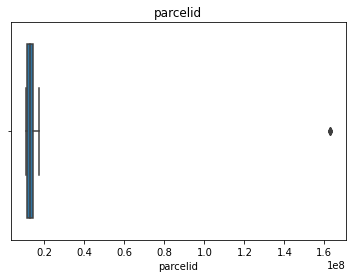

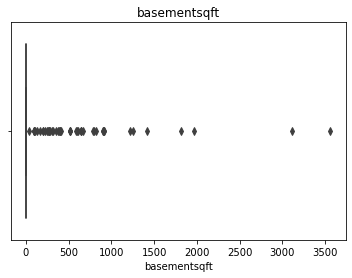

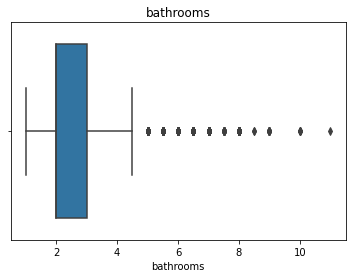

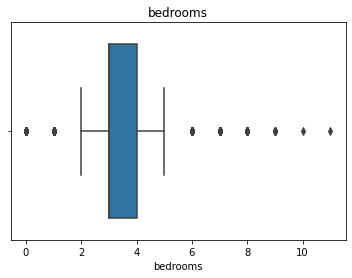

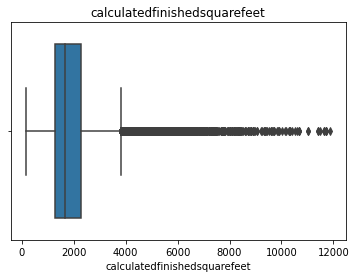

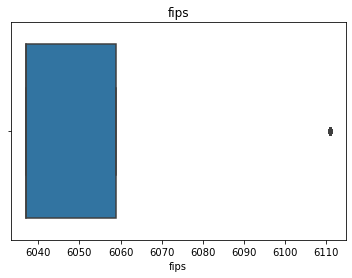

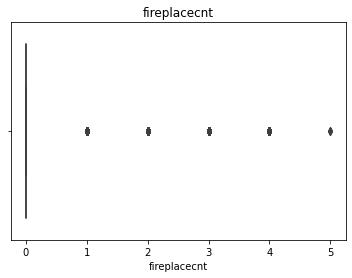

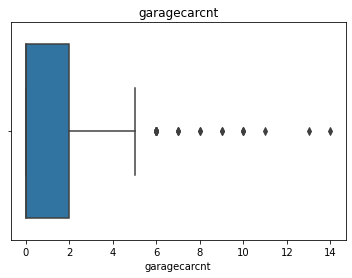

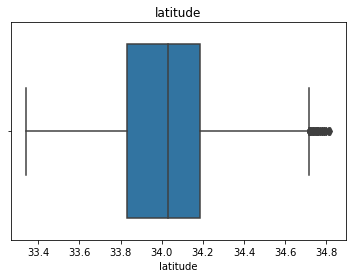

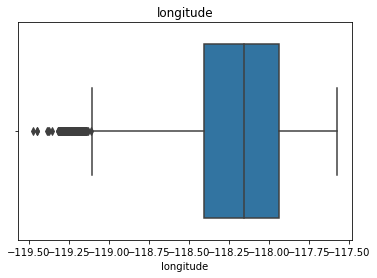

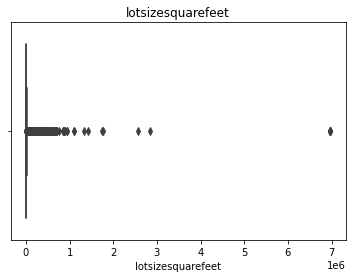

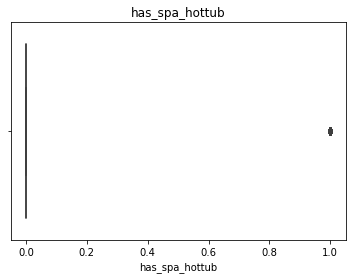

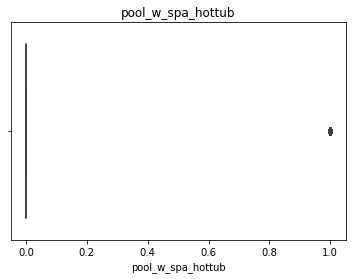

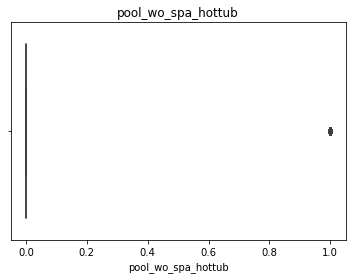

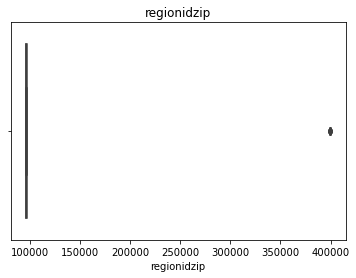

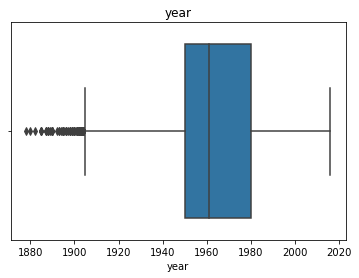

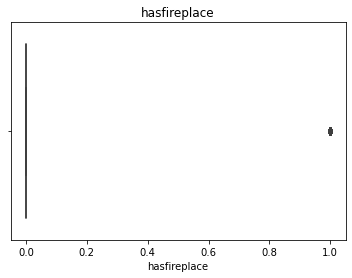

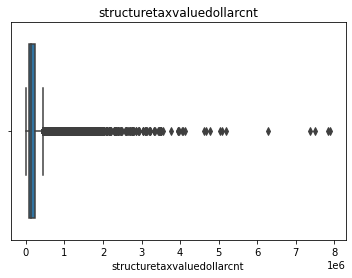

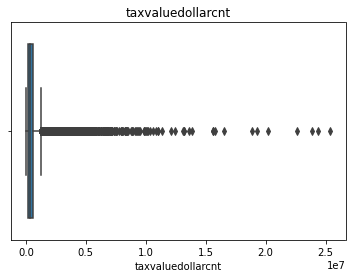

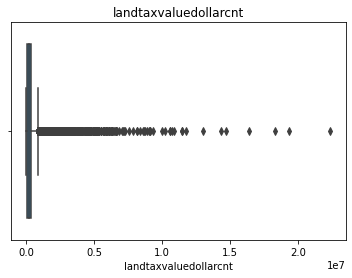

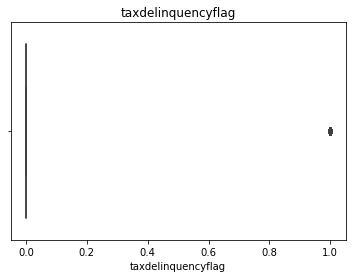

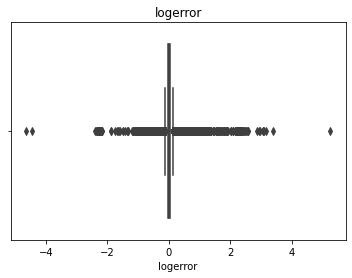

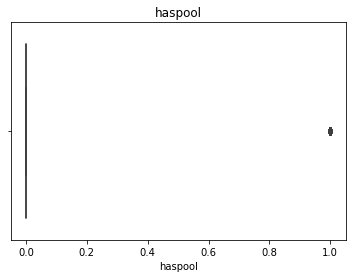

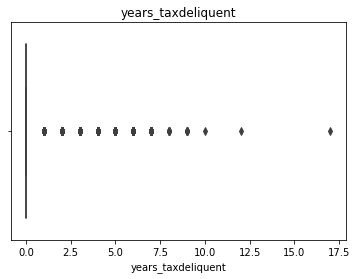

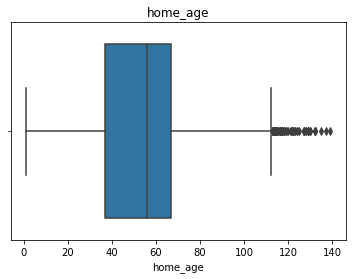

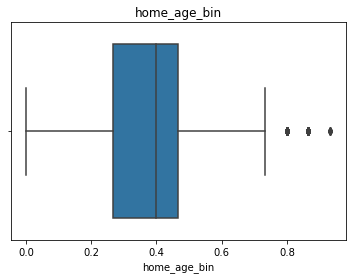

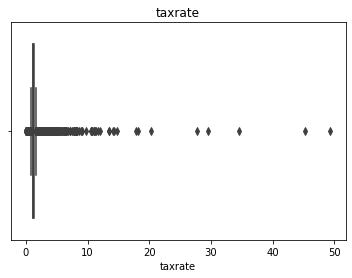

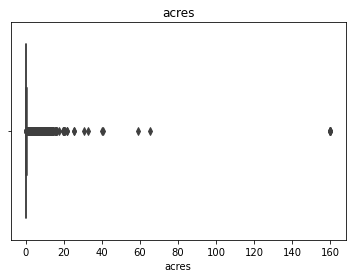

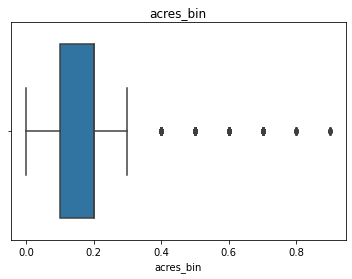

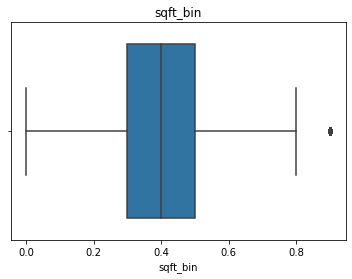

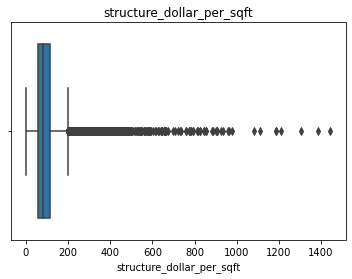

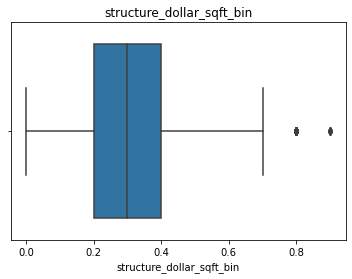

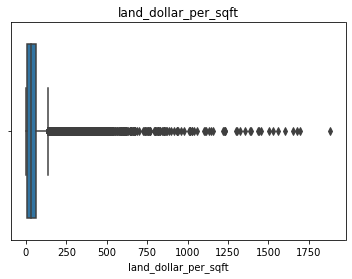

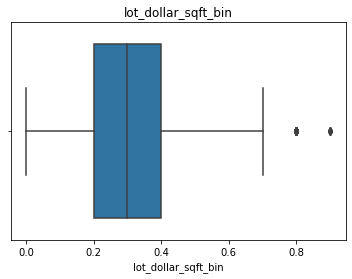

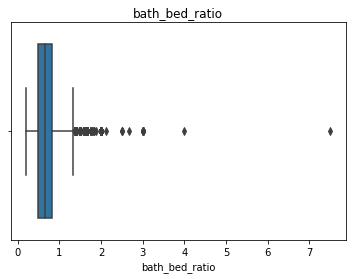

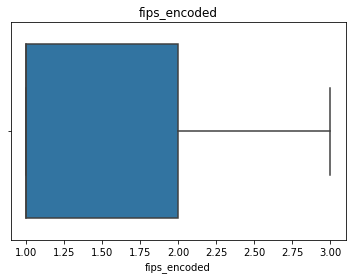

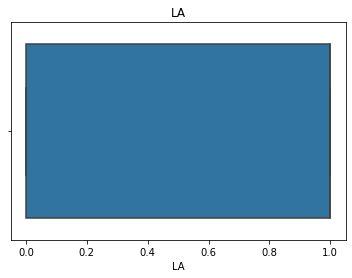

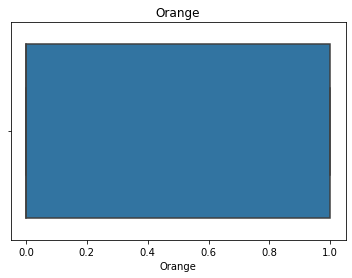

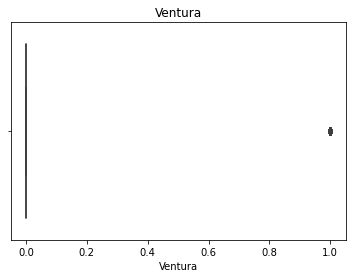

In [3]:
for col in df.select_dtypes(["int", "float", "uint8"]).columns:
    sns.boxplot(df[col])
    plt.title(col)
    plt.show()


# Remove Outliers

In [3]:
def remove_outliers():
    '''
    remove outliers in bed, bath, zip, square feet, acres & tax rate
    '''

    return df[((df.bathrooms <= 7) & (df.bedrooms <= 7) & 
               (df.regionidzip < 100000) & 
               (df.bathrooms > 0) & 
               (df.bedrooms > 0) & 
               (df.acres < 20) &
               (df.calculatedfinishedsquarefeet < 10000) & 
               (df.taxrate < 10) &
               (df.garagecarcnt <= 5)
              )]


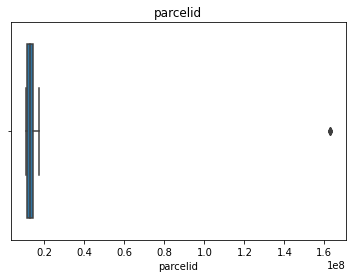

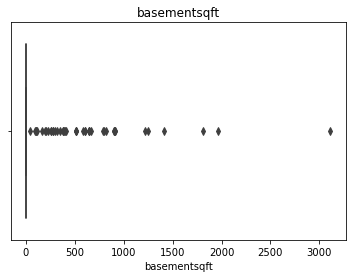

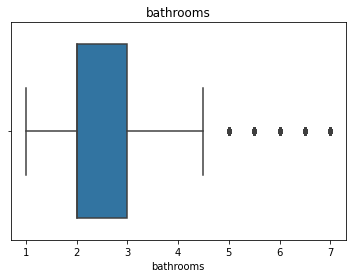

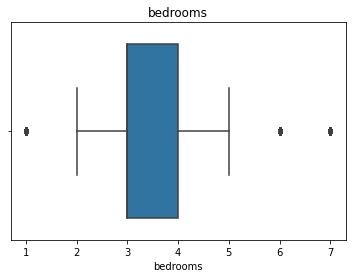

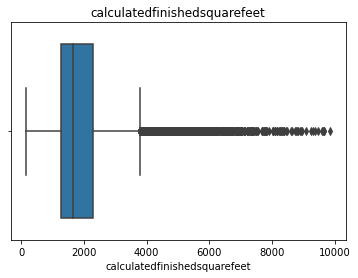

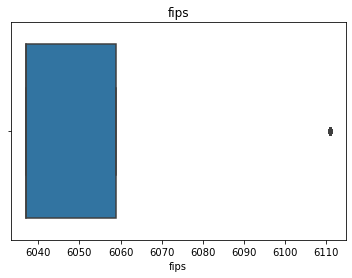

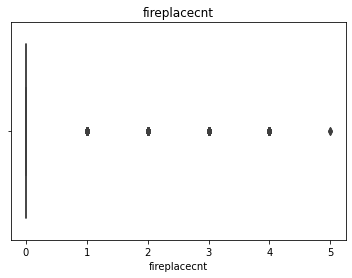

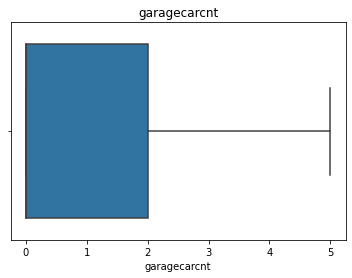

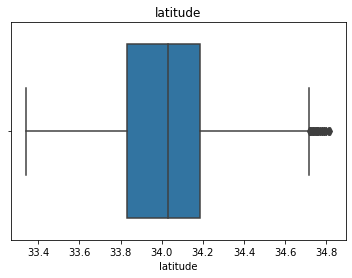

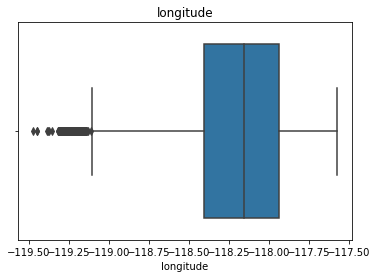

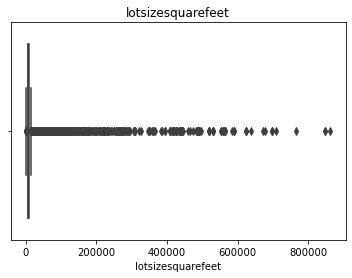

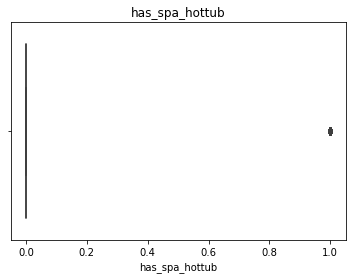

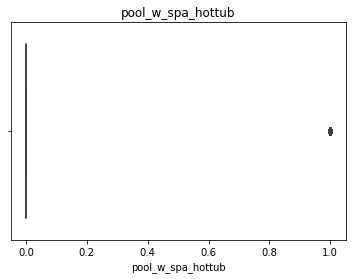

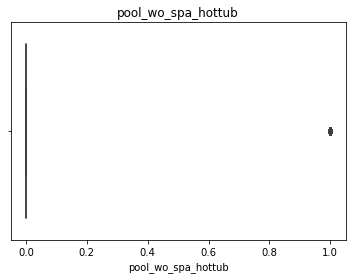

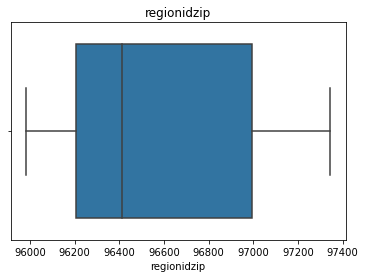

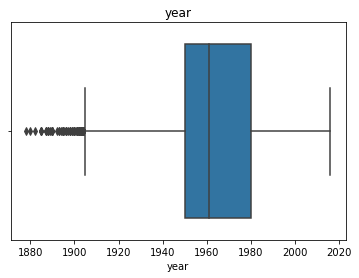

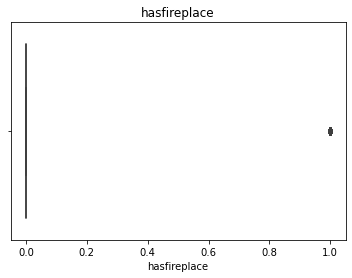

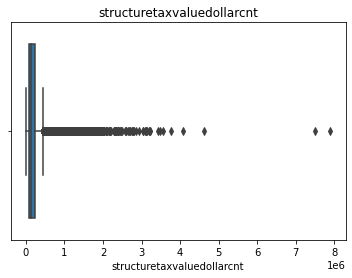

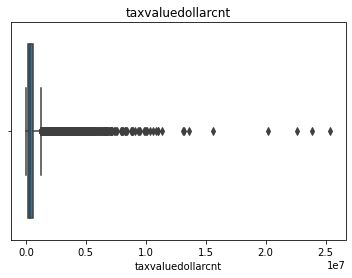

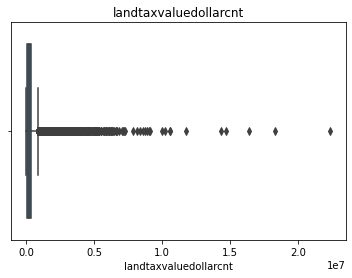

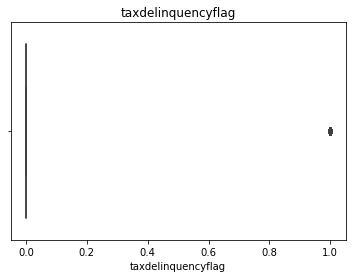

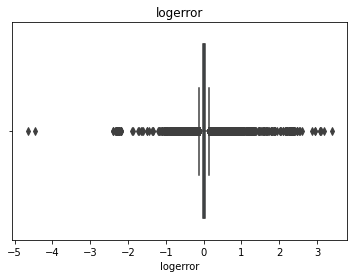

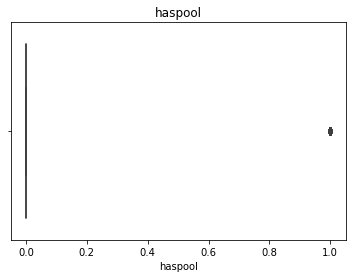

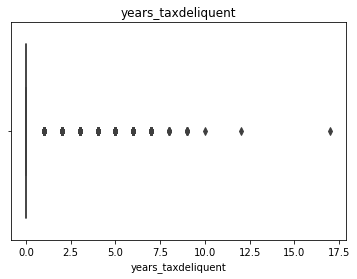

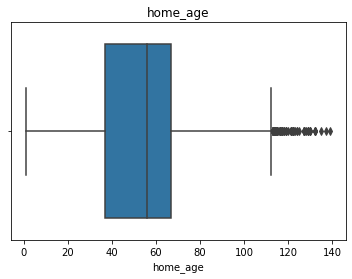

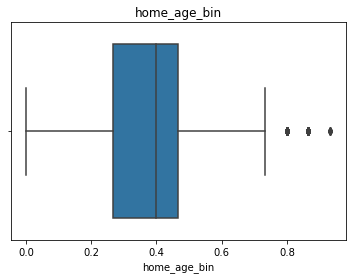

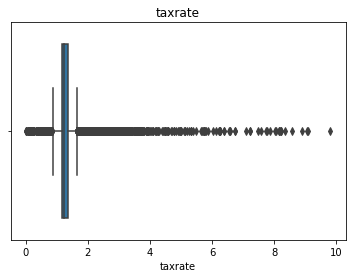

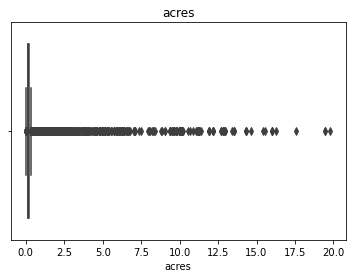

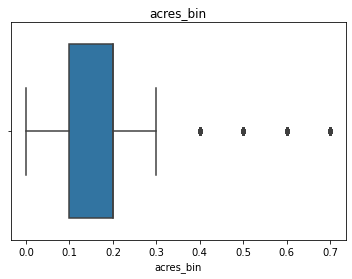

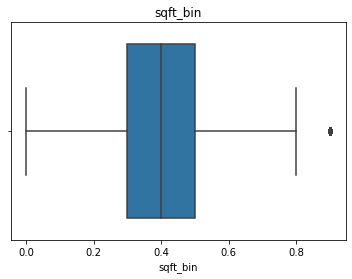

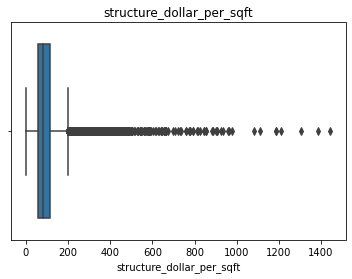

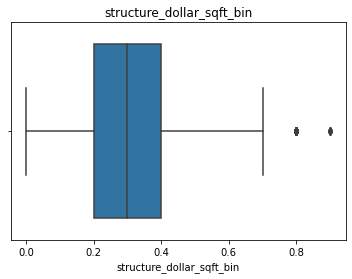

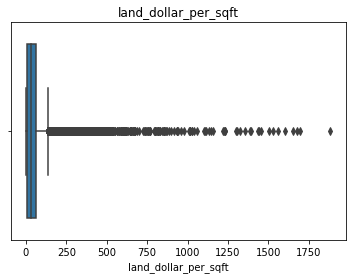

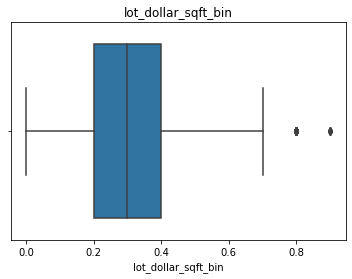

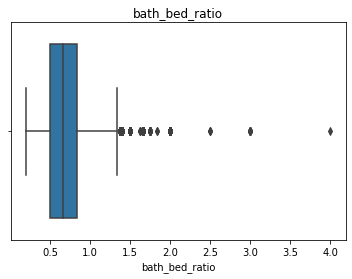

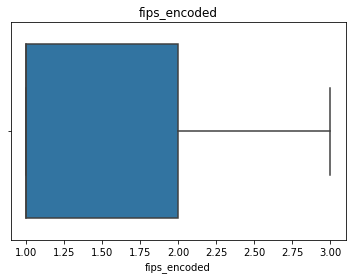

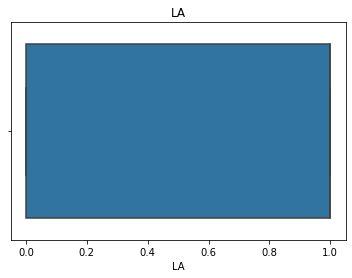

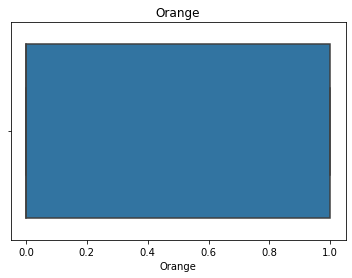

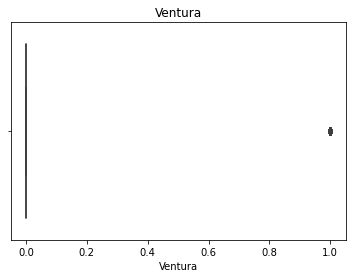

In [4]:
df = remove_outliers()
for col in df.select_dtypes(["int", "float", "uint8"]).columns:
    sns.boxplot(df[col])
    plt.title(col)
    plt.show()

In [10]:
df.columns

Index(['parcelid', 'basementsqft', 'bathrooms', 'bedrooms',
       'calculatedfinishedsquarefeet', 'fips', 'fireplacecnt', 'garagecarcnt',
       'latitude', 'longitude', 'lotsizesquarefeet', 'has_spa_hottub',
       'pool_w_spa_hottub', 'pool_wo_spa_hottub', 'regionidzip', 'year',
       'hasfireplace', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxdelinquencyflag', 'logerror',
       'transactiondate', 'haspool', 'years_taxdeliquent', 'home_age',
       'home_age_bin', 'taxrate', 'acres', 'acres_bin', 'sqft_bin',
       'structure_dollar_per_sqft', 'structure_dollar_sqft_bin',
       'land_dollar_per_sqft', 'lot_dollar_sqft_bin', 'bath_bed_ratio',
       'fips_encoded', 'LA', 'Orange', 'Ventura'],
      dtype='object')

In [5]:
df_la = df[df.LA == 1].drop(columns = ['parcelid',  'taxvaluedollarcnt', 'fips', 'fips_encoded',
                                       'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'year', 
                                       'lotsizesquarefeet', 'regionidzip', 'transactiondate',
                                       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 
                                       'LA', 'Ventura', 'Orange']) 


In [9]:
df_la.head()

,basementsqft,bathrooms,bedrooms,calculatedfinishedsquarefeet,fireplacecnt,garagecarcnt,latitude,longitude,has_spa_hottub,pool_w_spa_hottub,pool_wo_spa_hottub,hasfireplace,taxdelinquencyflag,logerror,haspool,years_taxdeliquent,home_age,home_age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_sqft_bin,lot_dollar_sqft_bin
3,0.00,3.00,4.00,"2,376.00",0.00,0.00,34.25,-118.24,0.00,0.00,1.00,0,0,-0.10,1,0.00,47.00,0.33,1.22,0.30,0.30,0.50,0.10,0.10
4,0.00,3.00,4.00,"2,962.00",0.00,0.00,34.15,-118.18,0.00,0.00,1.00,0,0,-0.00,1,0.00,67.00,0.47,1.23,1.45,0.50,0.60,0.30,0.20
5,0.00,1.00,2.00,738.00,0.00,0.00,34.15,-118.24,0.00,0.00,0.00,0,0,0.10,0,0.00,95.00,0.67,1.08,0.10,0.00,0.00,0.10,0.30
6,0.00,3.00,4.00,"3,039.00",0.00,0.00,33.96,-118.01,0.00,0.00,0.00,0,0,-0.04,0,0.00,47.00,0.33,1.41,0.46,0.30,0.70,0.20,0.10
7,0.00,3.00,4.00,"2,540.00",0.00,0.00,34.43,-118.46,0.00,0.00,1.00,0,0,0.01,1,0.00,18.00,0.13,1.42,0.24,0.20,0.60,0.40,0.20


In [6]:
df_ventura = df[df.Ventura == 1].drop(columns = ['parcelid',  'taxvaluedollarcnt', 'fips', 'fips_encoded',
                                       'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'year', 
                                       'lotsizesquarefeet', 'regionidzip', 'transactiondate',
                                       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 
                                       'LA', 'Ventura', 'Orange']) 


In [7]:
df_orange = df[df.Orange == 1].drop(columns = ['parcelid',  'taxvaluedollarcnt', 'fips', 'fips_encoded',
                                       'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'year', 
                                       'lotsizesquarefeet', 'regionidzip', 'transactiondate',
                                       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 
                                       'LA', 'Ventura', 'Orange']) 

In [46]:
def subsets():
    df_la, df_ventura, df_orange = df[df.LA == 1].drop(columns = ['parcelid',  'taxvaluedollarcnt', 'fips', 'fips_encoded',
                                        'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'year', 
                                        'lotsizesquarefeet', 'regionidzip', 'transactiondate',
                                        'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 
                                        'LA', 'Ventura', 'Orange']) ,df[df.Ventura == 1].drop(columns = ['parcelid',  'taxvaluedollarcnt', 'fips', 'fips_encoded',
                                        'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'year', 
                                        'lotsizesquarefeet', 'regionidzip', 'transactiondate',
                                        'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 
                                        'LA', 'Ventura', 'Orange']) , df[df.Orange == 1].drop(columns = ['parcelid',  'taxvaluedollarcnt', 'fips', 'fips_encoded',
                                        'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'year', 
                                        'lotsizesquarefeet', 'regionidzip', 'transactiondate',
                                        'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 
                                        'LA', 'Ventura', 'Orange'])
    return df_la, df_ventura, df_orange

In [49]:
subsets

<function __main__.subsets()>

## Split into train, validate, and test samples

In [8]:
def split(df, target_var):
    '''
    This function takes in the dataframe and target variable name as arguments and then
    splits the dataframe into train , validate , & test 
    It will return a list containing the following dataframes: train (for exploration), 
    X_train, X_validate, X_test, y_train, y_validate, y_test
    '''
    # split df into train_validate (80%) and test (20%)
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    # split train_validate into train(70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

    # create X_train by dropping the target variable 
    X_train = train.drop(columns=[target_var])
    # create y_train by keeping only the target variable.
    y_train = train[[target_var]]

    # create X_validate by dropping the target variable 
    X_validate = validate.drop(columns=[target_var])
    # create y_validate by keeping only the target variable.
    y_validate = validate[[target_var]]

    # create X_test by dropping the target variable 
    X_test = test.drop(columns=[target_var])
    # create y_test by keeping only the target variable.
    y_test = test[[target_var]]

    partitions = [train, X_train, X_validate, X_test, y_train, y_validate, y_test]
    return partitions


In [9]:
partitions = split(df_la, target_var='logerror')


In [10]:
train = partitions[0]
train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])
partitions[0] = train


In [68]:
train.head()

,basementsqft,bathrooms,bedrooms,calculatedfinishedsquarefeet,fireplacecnt,garagecarcnt,latitude,longitude,has_spa_hottub,pool_w_spa_hottub,pool_wo_spa_hottub,hasfireplace,taxdelinquencyflag,logerror,haspool,years_taxdeliquent,home_age,home_age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_sqft_bin,lot_dollar_sqft_bin,logerror_bins
34305,0.00,1.00,3.00,"1,066.00",0.00,0.00,33.92,-118.14,0.00,0.00,0.00,0,0,-0.09,0,0.00,67.00,0.47,1.26,0.13,0.10,0.20,0.30,0.30,"(-0.2, -0.05]"
38319,0.00,2.00,3.00,"1,681.00",0.00,0.00,34.18,-118.30,0.00,0.00,0.00,0,0,0.05,0,0.00,94.00,0.67,1.25,0.28,0.30,0.40,0.10,0.10,"(0.05, 0.2]"
20613,0.00,3.00,2.00,"1,974.00",0.00,0.00,34.15,-118.04,0.00,0.00,0.00,0,0,0.01,0,0.00,59.00,0.40,1.19,0.27,0.30,0.40,0.40,0.30,"(-0.05, 0.05]"
53206,0.00,3.00,4.00,"2,537.00",0.00,0.00,33.74,-118.35,0.00,0.00,0.00,0,0,0.06,0,0.00,57.00,0.40,1.15,0.27,0.30,0.60,0.30,0.40,"(0.05, 0.2]"
48934,0.00,2.00,3.00,"1,426.00",0.00,0.00,34.69,-118.11,0.00,0.00,0.00,0,0,-0.01,0,0.00,47.00,0.33,1.67,0.18,0.20,0.30,0.30,0.10,"(-0.05, 0.05]"


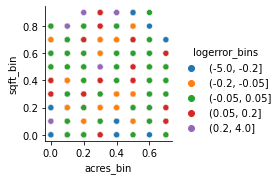

In [83]:
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['acres_bin'],
             y_vars = ['sqft_bin'])

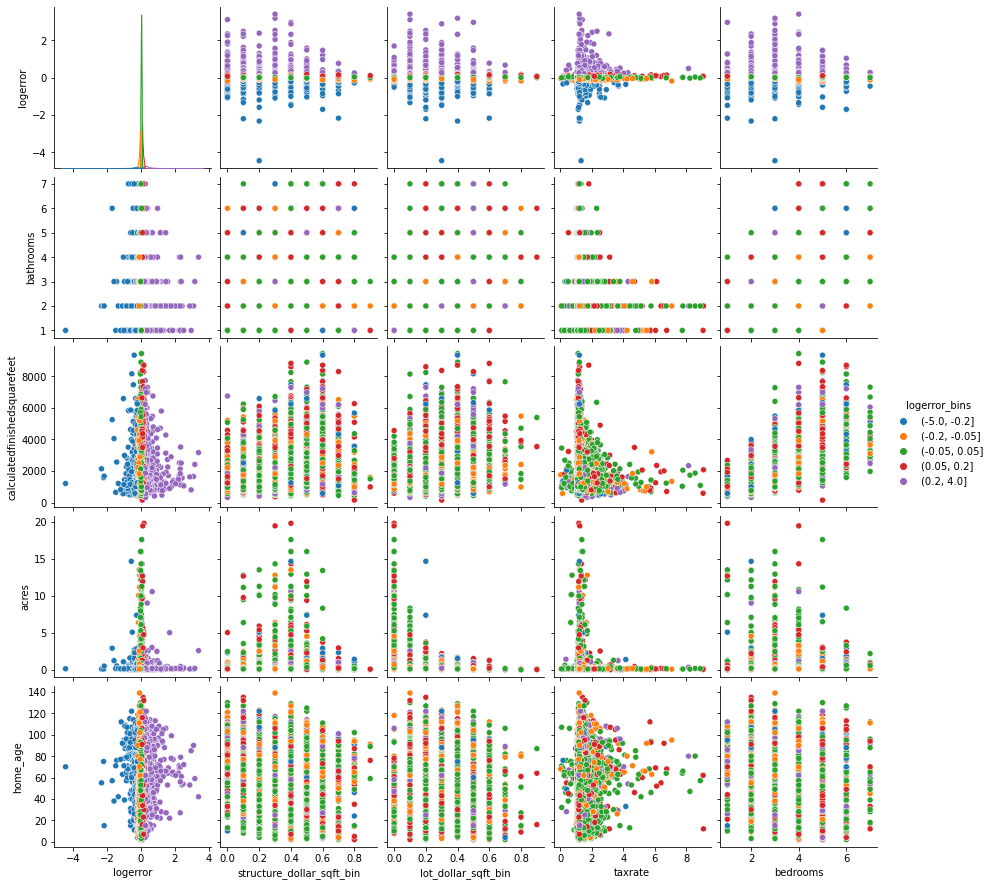

In [33]:
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror', 'structure_dollar_sqft_bin', 'lot_dollar_sqft_bin', 'taxrate', 
                       'bedrooms'],
             y_vars = ['logerror', 'bathrooms', 'calculatedfinishedsquarefeet', 'acres', 'home_age'])


In [34]:
df.head(2)

,parcelid,basementsqft,bathrooms,bedrooms,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,latitude,longitude,lotsizesquarefeet,has_spa_hottub,pool_w_spa_hottub,pool_wo_spa_hottub,regionidzip,year,hasfireplace,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxdelinquencyflag,logerror,transactiondate,haspool,years_taxdeliquent,home_age,home_age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,fips_encoded,LA,Orange,Ventura
0,14297519,0.00,3.50,4.00,"3,100.00","6,059.00",0.00,2.00,33.63,-117.87,"4,506.00",0.00,0.00,0.00,"96,978.00","1,998.00",0,"485,713.00","1,023,282.00","537,569.00",0,0.03,2017-01-01,0,0.00,19.00,0.13,1.08,0.10,0.10,0.70,156.68,0.50,119.30,0.50,0.88,2,0,1,0
1,17052889,0.00,1.00,2.00,"1,465.00","6,111.00",1.00,1.00,34.45,-119.28,"12,647.00",0.00,0.00,0.00,"97,099.00","1,967.00",1,"88,000.00","464,000.00","376,000.00",0,0.06,2017-01-01,0,0.00,50.00,0.33,1.22,0.29,0.30,0.30,60.07,0.20,29.73,0.30,0.50,3,0,0,1


In [11]:
# the variables that still need scaling
scaled_vars = ['latitude', 'longitude', 'bathrooms', 'bedrooms', 'taxrate', 'garagecarcnt', 'basementsqft', 'years_taxdeliquent' ]

# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]

# select the X partitions: [X_train, X_validate, X_test]
X = partitions[1:4]

# fit the minmaxscaler to X_train
X_train = X[0]
scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])


def scale_and_concat(df):
    scaled_array = scaler.transform(df[scaled_vars])
    scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
    return pd.concat((df, scaled_df), axis=1)

for i in range(len(X)):
    X[i] = scale_and_concat(X[i])


In [146]:
# recall: X[0] is X_train, X[1] is X_validate and X[2] is X_test
X[0].describe()


,basementsqft,bathrooms,bedrooms,calculatedfinishedsquarefeet,fireplacecnt,garagecarcnt,latitude,longitude,has_spa_hottub,pool_w_spa_hottub,pool_wo_spa_hottub,hasfireplace,taxdelinquencyflag,haspool,years_taxdeliquent,home_age,home_age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_sqft_bin,lot_dollar_sqft_bin,scaled_latitude,scaled_longitude,scaled_bathrooms,scaled_bedrooms,scaled_taxrate,scaled_garagecarcnt,scaled_basementsqft,scaled_years_taxdeliquent
count,"19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00","19,257.00"
mean,0.00,2.20,3.19,"1,792.81",0.00,0.00,34.12,-118.24,0.00,0.00,0.20,0.00,0.05,0.20,0.10,58.93,0.42,1.39,0.27,0.17,0.37,0.28,0.27,0.53,0.52,0.20,0.36,0.15,0.00,0.00,0.01
std,0.00,1.00,0.91,882.76,0.00,0.01,0.23,0.22,0.00,0.00,0.40,0.00,0.22,0.40,0.57,23.00,0.16,0.38,0.74,0.11,0.18,0.15,0.13,0.16,0.18,0.17,0.15,0.04,0.01,0.00,0.03
min,0.00,1.00,1.00,152.00,0.00,0.00,33.34,-118.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.02,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,2.00,3.00,"1,210.00",0.00,0.00,33.96,-118.41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,45.00,0.33,1.21,0.13,0.10,0.20,0.20,0.20,0.42,0.39,0.17,0.33,0.13,0.00,0.00,0.00
50%,0.00,2.00,3.00,"1,564.00",0.00,0.00,34.09,-118.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,62.00,0.47,1.26,0.16,0.20,0.40,0.30,0.30,0.51,0.52,0.17,0.33,0.14,0.00,0.00,0.00
75%,0.00,3.00,4.00,"2,118.00",0.00,0.00,34.20,-118.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,70.00,0.47,1.42,0.20,0.20,0.50,0.40,0.40,0.59,0.64,0.33,0.50,0.15,0.00,0.00,0.00
max,0.00,7.00,7.00,"9,451.00",0.00,2.00,34.81,-117.65,0.00,0.00,1.00,0.00,1.00,1.00,17.00,139.00,0.93,9.09,19.80,0.70,0.90,0.90,0.90,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00


In [147]:
# recall: X[0] is X_train, X[1] is X_validate and X[2] is X_test
X[2].describe()


,basementsqft,bathrooms,bedrooms,calculatedfinishedsquarefeet,fireplacecnt,garagecarcnt,latitude,longitude,has_spa_hottub,pool_w_spa_hottub,pool_wo_spa_hottub,hasfireplace,taxdelinquencyflag,haspool,years_taxdeliquent,home_age,home_age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_sqft_bin,lot_dollar_sqft_bin,scaled_latitude,scaled_longitude,scaled_bathrooms,scaled_bedrooms,scaled_taxrate,scaled_garagecarcnt,scaled_basementsqft,scaled_years_taxdeliquent
count,"6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00","6,878.00"
mean,0.00,2.20,3.19,"1,792.31",0.00,0.00,34.12,-118.24,0.00,0.00,0.20,0.00,0.05,0.20,0.10,58.87,0.42,1.38,0.28,0.18,0.37,0.28,0.27,0.53,0.52,0.20,0.37,0.15,0.00,0.00,0.01
std,0.00,0.99,0.90,876.55,0.00,0.00,0.23,0.22,0.00,0.00,0.40,0.00,0.21,0.40,0.55,22.99,0.16,0.39,0.77,0.11,0.18,0.15,0.13,0.16,0.18,0.16,0.15,0.04,0.00,0.00,0.03
min,0.00,1.00,1.00,360.00,0.00,0.00,33.34,-118.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.15,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00
25%,0.00,2.00,3.00,"1,219.00",0.00,0.00,33.95,-118.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,45.00,0.33,1.21,0.13,0.10,0.20,0.20,0.20,0.42,0.39,0.17,0.33,0.13,0.00,0.00,0.00
50%,0.00,2.00,3.00,"1,560.00",0.00,0.00,34.09,-118.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,62.00,0.47,1.26,0.16,0.20,0.40,0.30,0.30,0.51,0.52,0.17,0.33,0.14,0.00,0.00,0.00
75%,0.00,3.00,4.00,"2,131.00",0.00,0.00,34.20,-118.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,70.00,0.47,1.42,0.21,0.20,0.50,0.40,0.40,0.59,0.64,0.33,0.50,0.15,0.00,0.00,0.00
max,0.00,7.00,7.00,"9,242.00",0.00,0.00,34.76,-117.69,0.00,0.00,1.00,0.00,1.00,1.00,9.00,132.00,0.93,8.22,14.33,0.70,0.90,0.90,0.80,0.97,0.97,1.00,1.00,0.90,0.00,0.00,0.53


## Create clusters

In [12]:
# Create area cluster

# list of variables I will cluster on. 
cluster_vars = ['scaled_latitude', 'scaled_longitude', 'home_age_bin']
cluster_name = 'area_cluster'
k_range = range(2,20)


In [17]:
def find_k(X_train, cluster_vars, k_range):
    k_range = range(2,20)
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

    return k_comparisons_df


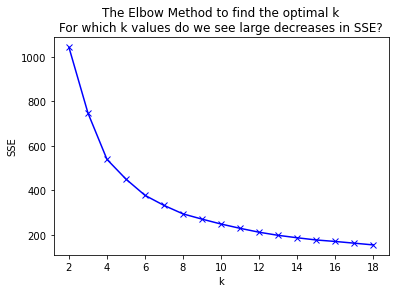

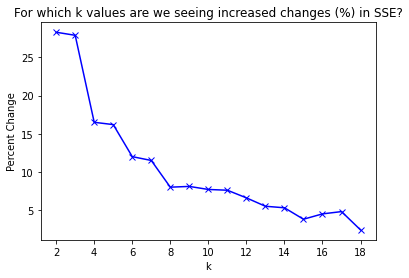

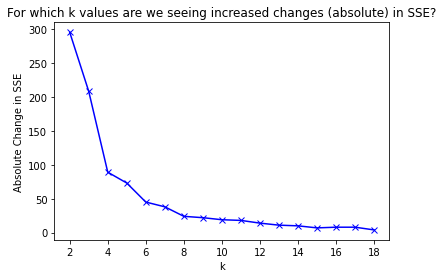

,k,sse,delta,pct_delta
0,2,"1,043.21",295.00,28.30
1,3,747.83,208.00,27.90
2,4,539.34,89.00,16.50
3,5,450.59,73.00,16.20
4,6,377.67,45.00,12.00
5,7,332.43,38.00,11.50
6,8,294.31,24.00,8.00
7,9,270.77,22.00,8.10
8,10,248.76,19.00,7.70
9,11,229.51,18.00,7.60


In [112]:
find_k(X[0], cluster_vars, k_range)


In [13]:
k = 4
# as reminders: 
cluster_vars = ['scaled_latitude', 'scaled_longitude', 'home_age_bin']
cluster_name = 'area_cluster'


In [14]:
def create_clusters(X_train, k, cluster_vars):
    # create kmean object
    kmeans = KMeans(n_clusters=k, random_state = 123)

    # fit to train and assign cluster ids to observations
    kmeans.fit(X_train[cluster_vars])

    return kmeans


In [15]:
kmeans = create_clusters(X[0], k, cluster_vars)


In [16]:
# get the centroids for each distinct cluster...

def get_centroids(kmeans, cluster_vars, cluster_name):
    # get the centroids for each distinct cluster...

    centroid_col_names = ['centroid_' + i for i in cluster_vars]

    centroid_df = pd.DataFrame(kmeans.cluster_centers_, 
                               columns=centroid_col_names).reset_index().rename(columns={'index': cluster_name})

    return centroid_df


In [17]:
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)


In [18]:
# label cluster for each observation in X_train (X[0] in our X list of dataframes), 
# X_validate (X[1]), & X_test (X[2])

def assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df):
    for i in range(len(X)):
        clusters = pd.DataFrame(kmeans.predict(X[i][cluster_vars]), 
                            columns=[cluster_name], index=X[i].index)

        clusters_centroids = clusters.merge(centroid_df, on=cluster_name, copy=False).set_index(clusters.index.values)

        X[i] = pd.concat([X[i], clusters_centroids], axis=1)
    return X


In [19]:
X = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df)


In [20]:
X[0]

,basementsqft,bathrooms,bedrooms,calculatedfinishedsquarefeet,fireplacecnt,garagecarcnt,latitude,longitude,has_spa_hottub,pool_w_spa_hottub,pool_wo_spa_hottub,hasfireplace,taxdelinquencyflag,haspool,years_taxdeliquent,home_age,home_age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_sqft_bin,lot_dollar_sqft_bin,bath_bed_ratio,scaled_latitude,scaled_longitude,scaled_bathrooms,scaled_bedrooms,scaled_taxrate,scaled_garagecarcnt,scaled_basementsqft,scaled_years_taxdeliquent,area_cluster,centroid_scaled_latitude,centroid_scaled_longitude,centroid_home_age_bin
34305,0.00,1.00,3.00,"1,066.00",0.00,0.00,33.92,-118.14,0.00,0.00,0.00,0,0,0,0.00,67.00,0.47,1.26,0.13,0.10,0.20,0.30,0.30,0.33,0.40,0.61,0.00,0.33,0.14,0.00,0.00,0.00,1,0.46,0.73,0.39
38319,0.00,2.00,3.00,"1,681.00",0.00,0.00,34.18,-118.30,0.00,0.00,0.00,0,0,0,0.00,94.00,0.67,1.25,0.28,0.30,0.40,0.10,0.10,0.67,0.57,0.48,0.17,0.33,0.14,0.00,0.00,0.00,1,0.46,0.73,0.39
20613,0.00,3.00,2.00,"1,974.00",0.00,0.00,34.15,-118.04,0.00,0.00,0.00,0,0,0,0.00,59.00,0.40,1.19,0.27,0.30,0.40,0.40,0.30,1.50,0.55,0.68,0.33,0.17,0.13,0.00,0.00,0.00,1,0.46,0.73,0.39
53206,0.00,3.00,4.00,"2,537.00",0.00,0.00,33.74,-118.35,0.00,0.00,0.00,0,0,0,0.00,57.00,0.40,1.15,0.27,0.30,0.60,0.30,0.40,0.75,0.27,0.43,0.33,0.50,0.12,0.00,0.00,0.00,1,0.46,0.73,0.39
48934,0.00,2.00,3.00,"1,426.00",0.00,0.00,34.69,-118.11,0.00,0.00,0.00,0,0,0,0.00,47.00,0.33,1.67,0.18,0.20,0.30,0.30,0.10,0.67,0.92,0.63,0.17,0.33,0.18,0.00,0.00,0.00,1,0.46,0.73,0.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,0.00,1.00,3.00,991.00,0.00,0.00,34.04,-118.42,0.00,0.00,0.00,0,0,0,0.00,72.00,0.53,1.30,0.14,0.10,0.10,0.10,0.20,0.33,0.48,0.38,0.00,0.33,0.14,0.00,0.00,0.00,0,0.59,0.31,0.35
52052,0.00,2.00,3.00,"1,357.00",0.00,0.00,33.90,-118.08,0.00,0.00,0.00,0,0,0,0.00,67.00,0.47,1.74,0.13,0.10,0.30,0.10,0.10,0.67,0.38,0.65,0.17,0.33,0.19,0.00,0.00,0.00,0,0.59,0.31,0.35
32099,0.00,2.00,4.00,"1,601.00",0.00,0.00,34.23,-118.48,0.00,0.00,0.00,0,0,0,0.00,57.00,0.40,1.30,0.21,0.20,0.40,0.30,0.20,0.50,0.61,0.33,0.17,0.50,0.14,0.00,0.00,0.00,0,0.59,0.31,0.35
49162,0.00,3.00,4.00,"2,129.00",0.00,0.00,33.82,-118.07,0.00,0.00,0.00,0,0,0,0.00,53.00,0.40,1.20,0.13,0.10,0.50,0.40,0.40,0.75,0.33,0.66,0.33,0.50,0.13,0.00,0.00,0.00,0,0.59,0.31,0.35


Size Cluster

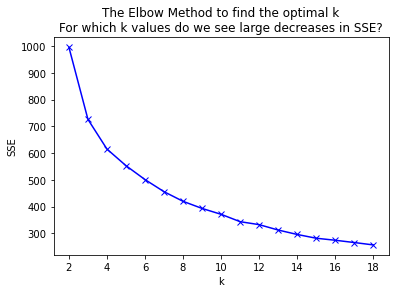

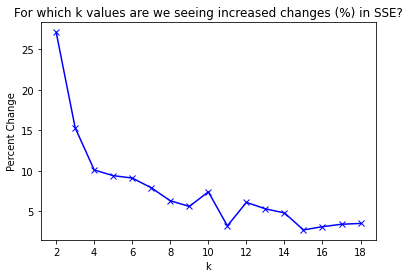

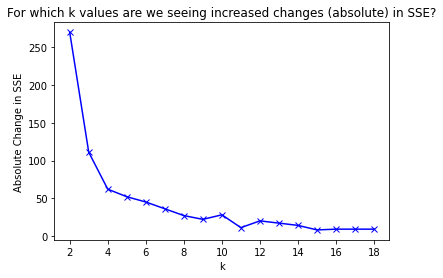

,k,sse,delta,pct_delta
0,2,995.84,270.00,27.10
1,3,725.98,111.00,15.30
2,4,614.80,62.00,10.10
3,5,552.76,52.00,9.40
4,6,500.69,45.00,9.10
5,7,455.38,36.00,7.90
6,8,419.37,27.00,6.30
7,9,392.76,22.00,5.60
8,10,370.78,28.00,7.40
9,11,343.22,11.00,3.20


In [158]:
cluster_vars = ['scaled_bathrooms', 'sqft_bin', 'acres_bin', 'scaled_bedrooms']
cluster_name = 'size_cluster'
k_range = range(2,20)

find_k(X[0], cluster_vars, k_range)


In [21]:
k=6
cluster_name = 'size_cluster'
cluster_vars = ['scaled_bathrooms', 'sqft_bin', 'acres_bin', 'scaled_bedrooms']

# fit kmeans 
kmeans = create_clusters(X[0], k, cluster_vars)

# get centroid values per variable per cluster
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)

# get cluster assignments and append those with centroids for each X partition (train, validate, test)
X = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df)


In [ ]:
X_train = X[0].iloc[:,0:27]


In [161]:
X[0]

,basementsqft,bathrooms,bedrooms,calculatedfinishedsquarefeet,fireplacecnt,garagecarcnt,latitude,longitude,has_spa_hottub,pool_w_spa_hottub,pool_wo_spa_hottub,hasfireplace,taxdelinquencyflag,haspool,years_taxdeliquent,home_age,home_age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_sqft_bin,lot_dollar_sqft_bin,scaled_latitude,scaled_longitude,scaled_bathrooms,scaled_bedrooms,scaled_taxrate,scaled_garagecarcnt,scaled_basementsqft,scaled_years_taxdeliquent,area_cluster,centroid_scaled_latitude,centroid_scaled_longitude,centroid_home_age_bin,size_cluster,centroid_scaled_bathrooms,centroid_sqft_bin,centroid_acres_bin,centroid_scaled_bedrooms,size_cluster,centroid_scaled_bathrooms,centroid_sqft_bin,centroid_acres_bin,centroid_scaled_bedrooms
34305,0.00,1.00,3.00,"1,066.00",0.00,0.00,33.92,-118.14,0.00,0.00,0.00,0,0,0,0.00,67.00,0.47,1.26,0.13,0.10,0.20,0.30,0.30,0.40,0.61,0.00,0.33,0.14,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,4,0.02,0.14,0.12,0.21
38319,0.00,2.00,3.00,"1,681.00",0.00,0.00,34.18,-118.30,0.00,0.00,0.00,0,0,0,0.00,94.00,0.67,1.25,0.28,0.30,0.40,0.10,0.10,0.57,0.48,0.17,0.33,0.14,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,4,0.02,0.14,0.12,0.21
20613,0.00,3.00,2.00,"1,974.00",0.00,0.00,34.15,-118.04,0.00,0.00,0.00,0,0,0,0.00,59.00,0.40,1.19,0.27,0.30,0.40,0.40,0.30,0.55,0.68,0.33,0.17,0.13,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,4,0.02,0.14,0.12,0.21
53206,0.00,3.00,4.00,"2,537.00",0.00,0.00,33.74,-118.35,0.00,0.00,0.00,0,0,0,0.00,57.00,0.40,1.15,0.27,0.30,0.60,0.30,0.40,0.27,0.43,0.33,0.50,0.12,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,4,0.02,0.14,0.12,0.21
48934,0.00,2.00,3.00,"1,426.00",0.00,0.00,34.69,-118.11,0.00,0.00,0.00,0,0,0,0.00,47.00,0.33,1.67,0.18,0.20,0.30,0.30,0.10,0.92,0.63,0.17,0.33,0.18,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,4,0.02,0.14,0.12,0.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,0.00,1.00,3.00,991.00,0.00,0.00,34.04,-118.42,0.00,0.00,0.00,0,0,0,0.00,72.00,0.53,1.30,0.14,0.10,0.10,0.10,0.20,0.48,0.38,0.00,0.33,0.14,0.00,0.00,0.00,0,0.59,0.31,0.35,5,0.16,0.37,0.17,0.51,5,0.16,0.37,0.17,0.51
52052,0.00,2.00,3.00,"1,357.00",0.00,0.00,33.90,-118.08,0.00,0.00,0.00,0,0,0,0.00,67.00,0.47,1.74,0.13,0.10,0.30,0.10,0.10,0.38,0.65,0.17,0.33,0.19,0.00,0.00,0.00,0,0.59,0.31,0.35,5,0.16,0.37,0.17,0.51,5,0.16,0.37,0.17,0.51
32099,0.00,2.00,4.00,"1,601.00",0.00,0.00,34.23,-118.48,0.00,0.00,0.00,0,0,0,0.00,57.00,0.40,1.30,0.21,0.20,0.40,0.30,0.20,0.61,0.33,0.17,0.50,0.14,0.00,0.00,0.00,0,0.59,0.31,0.35,5,0.16,0.37,0.17,0.51,5,0.16,0.37,0.17,0.51
49162,0.00,3.00,4.00,"2,129.00",0.00,0.00,33.82,-118.07,0.00,0.00,0.00,0,0,0,0.00,53.00,0.40,1.20,0.13,0.10,0.50,0.40,0.40,0.33,0.66,0.33,0.50,0.13,0.00,0.00,0.00,0,0.59,0.31,0.35,5,0.16,0.37,0.17,0.51,5,0.16,0.37,0.17,0.51


In [169]:
X_train = X[0].iloc[:,0:27]


In [172]:
X_train.head()

,basementsqft,bathrooms,bedrooms,calculatedfinishedsquarefeet,fireplacecnt,garagecarcnt,latitude,longitude,has_spa_hottub,pool_w_spa_hottub,pool_wo_spa_hottub,hasfireplace,taxdelinquencyflag,haspool,years_taxdeliquent,home_age,home_age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_sqft_bin,lot_dollar_sqft_bin,scaled_latitude,scaled_longitude,scaled_bathrooms,scaled_bedrooms
34305,0.00,1.00,3.00,"1,066.00",0.00,0.00,33.92,-118.14,0.00,0.00,0.00,0,0,0,0.00,67.00,0.47,1.26,0.13,0.10,0.20,0.30,0.30,0.40,0.61,0.00,0.33
38319,0.00,2.00,3.00,"1,681.00",0.00,0.00,34.18,-118.30,0.00,0.00,0.00,0,0,0,0.00,94.00,0.67,1.25,0.28,0.30,0.40,0.10,0.10,0.57,0.48,0.17,0.33
20613,0.00,3.00,2.00,"1,974.00",0.00,0.00,34.15,-118.04,0.00,0.00,0.00,0,0,0,0.00,59.00,0.40,1.19,0.27,0.30,0.40,0.40,0.30,0.55,0.68,0.33,0.17
53206,0.00,3.00,4.00,"2,537.00",0.00,0.00,33.74,-118.35,0.00,0.00,0.00,0,0,0,0.00,57.00,0.40,1.15,0.27,0.30,0.60,0.30,0.40,0.27,0.43,0.33,0.50
48934,0.00,2.00,3.00,"1,426.00",0.00,0.00,34.69,-118.11,0.00,0.00,0.00,0,0,0,0.00,47.00,0.33,1.67,0.18,0.20,0.30,0.30,0.10,0.92,0.63,0.17,0.33


Taxes due cluster

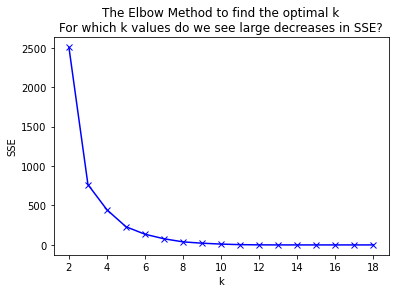

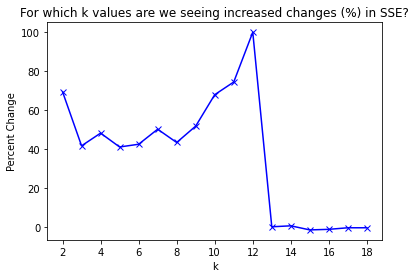

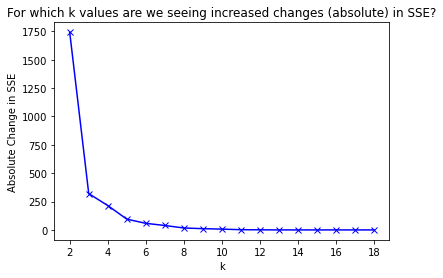

,k,sse,delta,pct_delta
0,2,"2,506.92","1,742.00",69.50
1,3,765.22,320.00,41.80
2,4,445.12,215.00,48.30
3,5,230.32,95.00,41.20
4,6,135.36,58.00,42.60
5,7,77.68,39.00,50.30
6,8,38.63,17.00,43.50
7,9,21.83,11.00,51.90
8,10,10.50,7.00,68.00
9,11,3.36,2.00,74.50


In [162]:
cluster_vars = ['taxdelinquencyflag', 'years_taxdeliquent']
cluster_name = 'tax_due_cluster'
k_range = range(2,20)

find_k(X[0], cluster_vars, k_range)


In [22]:
k=3
cluster_name = 'tax_due_cluster'
cluster_vars = ['taxdelinquencyflag', 'years_taxdeliquent']

# fit kmeans 
kmeans = create_clusters(X[0], k, cluster_vars)

# get centroid values per variable per cluster
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)

# get cluster assignments and append those with centroids for each X partition (train, validate, test)
X = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df)

In [164]:
X[0]

,basementsqft,bathrooms,bedrooms,calculatedfinishedsquarefeet,fireplacecnt,garagecarcnt,latitude,longitude,has_spa_hottub,pool_w_spa_hottub,pool_wo_spa_hottub,hasfireplace,taxdelinquencyflag,haspool,years_taxdeliquent,home_age,home_age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_sqft_bin,lot_dollar_sqft_bin,scaled_latitude,scaled_longitude,scaled_bathrooms,scaled_bedrooms,scaled_taxrate,scaled_garagecarcnt,scaled_basementsqft,scaled_years_taxdeliquent,area_cluster,centroid_scaled_latitude,centroid_scaled_longitude,centroid_home_age_bin,size_cluster,centroid_scaled_bathrooms,centroid_sqft_bin,centroid_acres_bin,centroid_scaled_bedrooms,size_cluster,centroid_scaled_bathrooms,centroid_sqft_bin,centroid_acres_bin,centroid_scaled_bedrooms,tax_due_cluster,centroid_taxdelinquencyflag,centroid_years_taxdeliquent
34305,0.00,1.00,3.00,"1,066.00",0.00,0.00,33.92,-118.14,0.00,0.00,0.00,0,0,0,0.00,67.00,0.47,1.26,0.13,0.10,0.20,0.30,0.30,0.40,0.61,0.00,0.33,0.14,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,4,0.02,0.14,0.12,0.21,0,-0.00,0.00
38319,0.00,2.00,3.00,"1,681.00",0.00,0.00,34.18,-118.30,0.00,0.00,0.00,0,0,0,0.00,94.00,0.67,1.25,0.28,0.30,0.40,0.10,0.10,0.57,0.48,0.17,0.33,0.14,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,4,0.02,0.14,0.12,0.21,0,-0.00,0.00
20613,0.00,3.00,2.00,"1,974.00",0.00,0.00,34.15,-118.04,0.00,0.00,0.00,0,0,0,0.00,59.00,0.40,1.19,0.27,0.30,0.40,0.40,0.30,0.55,0.68,0.33,0.17,0.13,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,4,0.02,0.14,0.12,0.21,0,-0.00,0.00
53206,0.00,3.00,4.00,"2,537.00",0.00,0.00,33.74,-118.35,0.00,0.00,0.00,0,0,0,0.00,57.00,0.40,1.15,0.27,0.30,0.60,0.30,0.40,0.27,0.43,0.33,0.50,0.12,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,4,0.02,0.14,0.12,0.21,0,-0.00,0.00
48934,0.00,2.00,3.00,"1,426.00",0.00,0.00,34.69,-118.11,0.00,0.00,0.00,0,0,0,0.00,47.00,0.33,1.67,0.18,0.20,0.30,0.30,0.10,0.92,0.63,0.17,0.33,0.18,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,4,0.02,0.14,0.12,0.21,0,-0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,0.00,1.00,3.00,991.00,0.00,0.00,34.04,-118.42,0.00,0.00,0.00,0,0,0,0.00,72.00,0.53,1.30,0.14,0.10,0.10,0.10,0.20,0.48,0.38,0.00,0.33,0.14,0.00,0.00,0.00,0,0.59,0.31,0.35,5,0.16,0.37,0.17,0.51,5,0.16,0.37,0.17,0.51,1,1.00,5.56
52052,0.00,2.00,3.00,"1,357.00",0.00,0.00,33.90,-118.08,0.00,0.00,0.00,0,0,0,0.00,67.00,0.47,1.74,0.13,0.10,0.30,0.10,0.10,0.38,0.65,0.17,0.33,0.19,0.00,0.00,0.00,0,0.59,0.31,0.35,5,0.16,0.37,0.17,0.51,5,0.16,0.37,0.17,0.51,1,1.00,5.56
32099,0.00,2.00,4.00,"1,601.00",0.00,0.00,34.23,-118.48,0.00,0.00,0.00,0,0,0,0.00,57.00,0.40,1.30,0.21,0.20,0.40,0.30,0.20,0.61,0.33,0.17,0.50,0.14,0.00,0.00,0.00,0,0.59,0.31,0.35,5,0.16,0.37,0.17,0.51,5,0.16,0.37,0.17,0.51,1,1.00,5.56
49162,0.00,3.00,4.00,"2,129.00",0.00,0.00,33.82,-118.07,0.00,0.00,0.00,0,0,0,0.00,53.00,0.40,1.20,0.13,0.10,0.50,0.40,0.40,0.33,0.66,0.33,0.50,0.13,0.00,0.00,0.00,0,0.59,0.31,0.35,5,0.16,0.37,0.17,0.51,5,0.16,0.37,0.17,0.51,1,1.00,5.56


Price Cluster

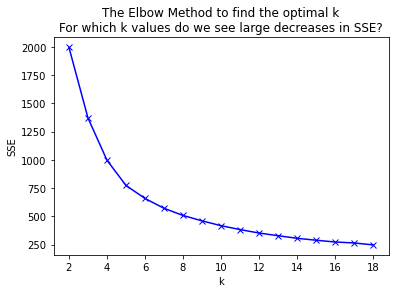

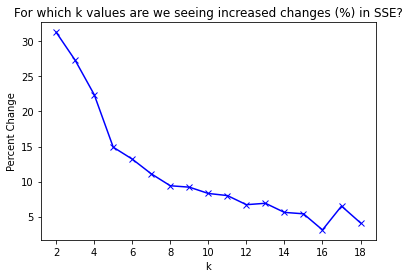

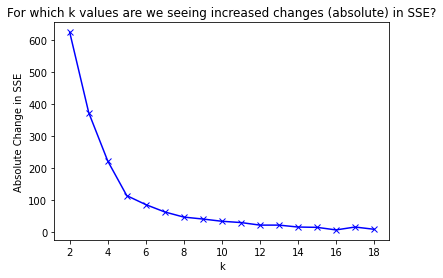

,k,sse,delta,pct_delta
0,2,"1,995.54",625.00,31.30
1,3,"1,370.71",374.00,27.30
2,4,996.77,223.00,22.40
3,5,773.30,115.00,14.90
4,6,658.21,87.00,13.20
5,7,571.28,64.00,11.10
6,8,507.75,48.00,9.40
7,9,459.95,42.00,9.20
8,10,417.54,35.00,8.30
9,11,382.89,31.00,8.00


In [165]:
cluster_vars = ['taxrate', 'structure_dollar_sqft_bin','lot_dollar_sqft_bin' ]
cluster_name = 'price_cluster'
k_range = range(2,20)

find_k(X[0], cluster_vars, k_range)


In [23]:
k=5
cluster_vars = ['taxrate', 'structure_dollar_sqft_bin','lot_dollar_sqft_bin' ]
cluster_name = 'price_cluster'

# fit kmeans 
kmeans = create_clusters(X[0], k, cluster_vars)

# get centroid values per variable per cluster
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)

# get cluster assignments and append those with centroids for each X partition (train, validate, test)
X = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df)

## Explore each cluster

Area cluster

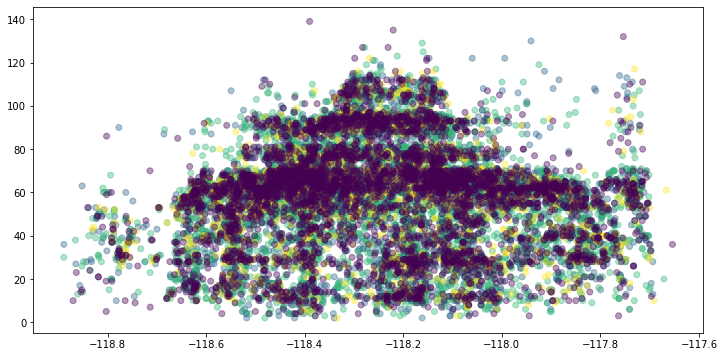

In [24]:
plt.figure(figsize=(12,6))
# plt.scatter(y=X_train.latitude, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)
plt.scatter(y=X[0].home_age, x=X[0].longitude, c=X[0].area_cluster, alpha=.4)


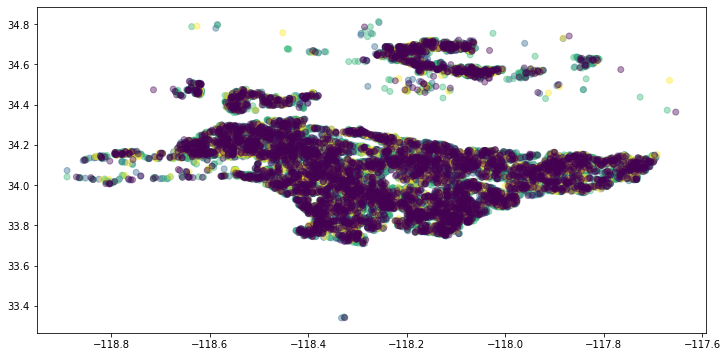

In [25]:
plt.figure(figsize=(12,6))
plt.scatter(y=X[0].latitude, x=X[0].longitude, c=X[0].area_cluster, alpha=.4)

Text(0.5, 1.0, 'Do clusters reveal differences in age and error?')

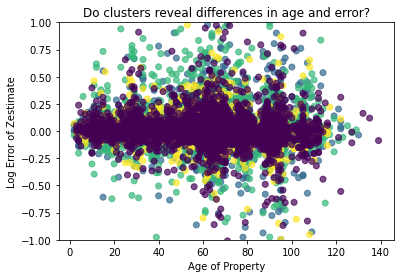

In [26]:
y_train = partitions[-3]

plt.scatter(y=y_train.logerror, x=X[0].home_age, c=X[0].area_cluster, alpha=.7)
plt.ylim(-1,1)
plt.xlabel('Age of Property')
plt.ylabel('Log Error of Zestimate')
plt.title("Do clusters reveal differences in age and error?")


(-1.0, 1.0)

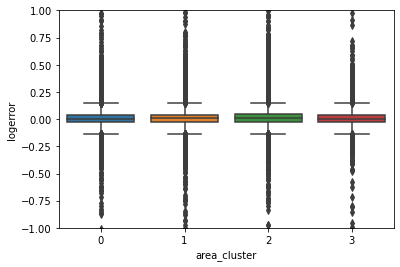

In [27]:

sns.boxplot(y=y_train.logerror, x=X[0].area_cluster)
plt.ylim(-1, 1)
# sns.swarmplot(X_train.age_bin, y_train.logerror, hue=X_train.area_cluster)


KeyboardInterrupt: 

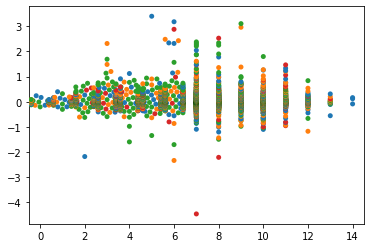

In [43]:
sns.swarmplot(X[0].home_age_bin, y_train.logerror, hue=X[0].area_cluster)
plt.ylim(-1, 1)

size cluster exploration

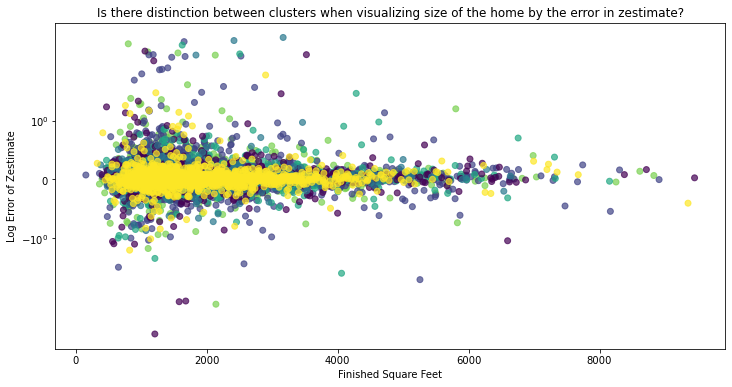

In [28]:
plt.figure(figsize=(12,6))
# plt.scatter(y=X_train.latitude, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)
plt.scatter(y=y_train.logerror, x=X[0].calculatedfinishedsquarefeet, c=X[0].size_cluster, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error of Zestimate')
plt.title('Is there distinction between clusters when visualizing size of the home by the error in zestimate?')

plt.show()


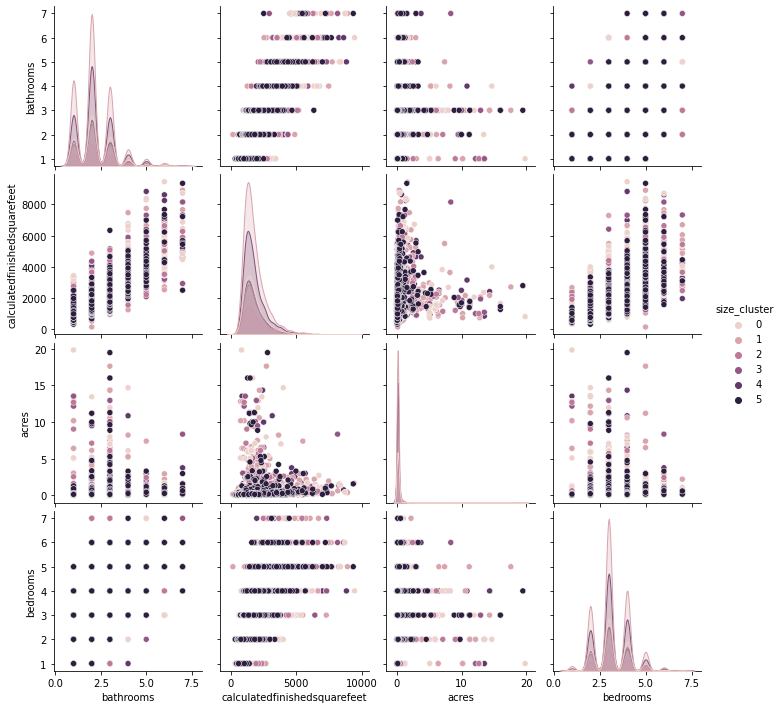

In [29]:
plt_df = X[0][['bathrooms', 'calculatedfinishedsquarefeet', 
                    'acres', 'bedrooms', 'size_cluster']]

sns.pairplot(data=plt_df, hue='size_cluster')


<AxesSubplot:xlabel='bath_bed_ratio', ylabel='calculatedfinishedsquarefeet'>

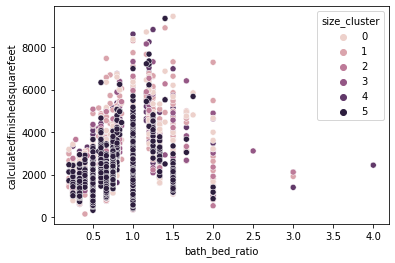

In [30]:
sns.scatterplot(x='bath_bed_ratio', y='calculatedfinishedsquarefeet', 
                data=X[0], hue='size_cluster')


Tax Due Cluster

<AxesSubplot:xlabel='years_taxdeliquent', ylabel='taxdelinquencyflag'>

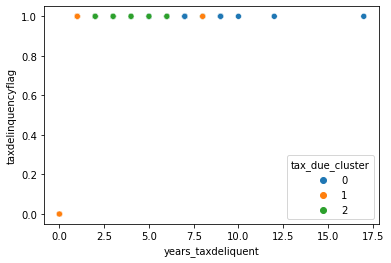

In [42]:
sns.scatterplot(x= 'years_taxdeliquent' , y= 'taxdelinquencyflag', 
                data=X[0], hue='tax_due_cluster')

                 

Price Cluster

In [32]:
X[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19257 entries, 34305 to 26422
Data columns (total 48 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   basementsqft                        19257 non-null  float64
 1   bathrooms                           19257 non-null  float64
 2   bedrooms                            19257 non-null  float64
 3   calculatedfinishedsquarefeet        19257 non-null  float64
 4   fireplacecnt                        19257 non-null  float64
 5   garagecarcnt                        19257 non-null  float64
 6   latitude                            19257 non-null  float64
 7   longitude                           19257 non-null  float64
 8   has_spa_hottub                      19257 non-null  float64
 9   pool_w_spa_hottub                   19257 non-null  float64
 10  pool_wo_spa_hottub                  19257 non-null  float64
 11  hasfireplace                        1

In [33]:
# update datatypes of binned values to be float
X[0] = X[0].astype({'size_cluster': 'category', 'area_cluster': 'category', 'price_cluster': 'category', 'tax_due_cluster': 'category' })


In [34]:
dummy_df = pd.get_dummies(X[0][['size_cluster','area_cluster', 'price_cluster', 'tax_due_cluster']], dummy_na=False, drop_first=[True, True])

# append dummy df cols to the original df. 
X[0] = pd.concat([X[0], dummy_df], axis=1)


In [35]:
X[0].head()

,basementsqft,bathrooms,bedrooms,calculatedfinishedsquarefeet,fireplacecnt,garagecarcnt,latitude,longitude,has_spa_hottub,pool_w_spa_hottub,pool_wo_spa_hottub,hasfireplace,taxdelinquencyflag,haspool,years_taxdeliquent,home_age,home_age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_sqft_bin,lot_dollar_sqft_bin,bath_bed_ratio,scaled_latitude,scaled_longitude,scaled_bathrooms,scaled_bedrooms,scaled_taxrate,scaled_garagecarcnt,scaled_basementsqft,scaled_years_taxdeliquent,area_cluster,centroid_scaled_latitude,centroid_scaled_longitude,centroid_home_age_bin,size_cluster,centroid_scaled_bathrooms,centroid_sqft_bin,centroid_acres_bin,centroid_scaled_bedrooms,tax_due_cluster,centroid_taxdelinquencyflag,centroid_years_taxdeliquent,price_cluster,centroid_taxrate,centroid_structure_dollar_sqft_bin,centroid_lot_dollar_sqft_bin,size_cluster_1,size_cluster_2,size_cluster_3,size_cluster_4,size_cluster_5,area_cluster_1,area_cluster_2,area_cluster_3,price_cluster_1,price_cluster_2,price_cluster_3,price_cluster_4,tax_due_cluster_1,tax_due_cluster_2
34305,0.00,1.00,3.00,"1,066.00",0.00,0.00,33.92,-118.14,0.00,0.00,0.00,0,0,0,0.00,67.00,0.47,1.26,0.13,0.10,0.20,0.30,0.30,0.33,0.40,0.61,0.00,0.33,0.14,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,0,-0.00,0.00,1,1.22,0.39,0.36,0,0,0,1,0,1,0,0,1,0,0,0,0,0
38319,0.00,2.00,3.00,"1,681.00",0.00,0.00,34.18,-118.30,0.00,0.00,0.00,0,0,0,0.00,94.00,0.67,1.25,0.28,0.30,0.40,0.10,0.10,0.67,0.57,0.48,0.17,0.33,0.14,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,0,-0.00,0.00,1,1.22,0.39,0.36,0,0,0,1,0,1,0,0,1,0,0,0,0,0
20613,0.00,3.00,2.00,"1,974.00",0.00,0.00,34.15,-118.04,0.00,0.00,0.00,0,0,0,0.00,59.00,0.40,1.19,0.27,0.30,0.40,0.40,0.30,1.50,0.55,0.68,0.33,0.17,0.13,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,0,-0.00,0.00,1,1.22,0.39,0.36,0,0,0,1,0,1,0,0,1,0,0,0,0,0
53206,0.00,3.00,4.00,"2,537.00",0.00,0.00,33.74,-118.35,0.00,0.00,0.00,0,0,0,0.00,57.00,0.40,1.15,0.27,0.30,0.60,0.30,0.40,0.75,0.27,0.43,0.33,0.50,0.12,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,0,-0.00,0.00,1,1.22,0.39,0.36,0,0,0,1,0,1,0,0,1,0,0,0,0,0
48934,0.00,2.00,3.00,"1,426.00",0.00,0.00,34.69,-118.11,0.00,0.00,0.00,0,0,0,0.00,47.00,0.33,1.67,0.18,0.20,0.30,0.30,0.10,0.67,0.92,0.63,0.17,0.33,0.18,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,0,-0.00,0.00,1,1.22,0.39,0.36,0,0,0,1,0,1,0,0,1,0,0,0,0,0


In [40]:
X[1].head()

,basementsqft,bathrooms,bedrooms,calculatedfinishedsquarefeet,fireplacecnt,garagecarcnt,latitude,longitude,has_spa_hottub,pool_w_spa_hottub,pool_wo_spa_hottub,hasfireplace,taxdelinquencyflag,haspool,years_taxdeliquent,home_age,home_age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_sqft_bin,lot_dollar_sqft_bin,bath_bed_ratio,scaled_latitude,scaled_longitude,scaled_bathrooms,scaled_bedrooms,scaled_taxrate,scaled_garagecarcnt,scaled_basementsqft,scaled_years_taxdeliquent,area_cluster,centroid_scaled_latitude,centroid_scaled_longitude,centroid_home_age_bin,size_cluster,centroid_scaled_bathrooms,centroid_sqft_bin,centroid_acres_bin,centroid_scaled_bedrooms,tax_due_cluster,centroid_taxdelinquencyflag,centroid_years_taxdeliquent,price_cluster,centroid_taxrate,centroid_structure_dollar_sqft_bin,centroid_lot_dollar_sqft_bin
7758,0.00,2.00,3.00,921.00,0.00,0.00,34.03,-117.96,0.00,0.00,0.00,0,0,0,0.00,63.00,0.47,2.13,0.14,0.10,0.10,0.10,0.10,0.67,0.47,0.75,0.17,0.33,0.23,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,0,-0.00,0.00,2,1.78,0.19,0.16
49047,0.00,2.00,3.00,"1,576.00",0.00,0.00,34.16,-118.01,0.00,0.00,0.00,0,0,0,0.00,94.00,0.67,1.75,0.20,0.20,0.40,0.00,0.10,0.67,0.55,0.71,0.17,0.33,0.19,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,0,-0.00,0.00,2,1.78,0.19,0.16
35610,0.00,2.00,3.00,"1,260.00",0.00,0.00,33.94,-118.00,0.00,0.00,0.00,0,0,0,0.00,65.00,0.47,1.53,0.19,0.20,0.30,0.10,0.10,0.67,0.41,0.72,0.17,0.33,0.17,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,0,-0.00,0.00,2,1.78,0.19,0.16
35191,0.00,1.00,2.00,"1,062.00",0.00,0.00,33.81,-118.19,0.00,0.00,0.00,0,0,0,0.00,75.00,0.53,1.23,0.12,0.10,0.20,0.20,0.40,0.50,0.32,0.56,0.00,0.17,0.13,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,0,-0.00,0.00,2,1.78,0.19,0.16
119,0.00,1.00,3.00,"1,306.00",0.00,0.00,33.97,-118.32,0.00,0.00,0.00,0,0,0,0.00,87.00,0.60,1.66,0.15,0.20,0.30,0.10,0.20,0.33,0.43,0.46,0.00,0.33,0.18,0.00,0.00,0.00,1,0.46,0.73,0.39,4,0.02,0.14,0.12,0.21,0,-0.00,0.00,2,1.78,0.19,0.16
